# **Clasificación de Imágenes para Identificar Tumores en el Cerebro**

## **Introducción**

Este proyecto se centra en el desarrollo de un modelo de Deep Learning para la clasificación automática de imágenes de resonancia magnética (*MRI*) con el fin de identificar diferentes tipos de tumores cerebrales. Este proyecto tiene implicaciones significativas en el ámbito de la salud, ya que un modelo preciso y eficiente puede complementar el diagnóstico médico, ofreciendo una herramienta que acelere y optimice el proceso de identificación de tumores.

### **Objetivo**
El principal objetivo es crear un modelo que pueda clasificar imágenes *MRI* en las siguientes categorías:
- **Glioma**
- **Meningioma**
- **Pituitario**
- **No Tumor**

El desarrollo de este modelo permitirá explorar el uso de redes neuronales convolucionales (*CNN*) para extraer patrones complejos en imágenes médicas, optimizando el rendimiento a través de ajustes en hiperparámetros y diferentes técnicas de procesamiento de datos.

### **Contexto**
El dataset utilizado para este proyecto fue obtenido de **Kaggle**, una plataforma que contiene conjuntos de datos de alta calidad para proyectos de Mchine Learning, Deep Learning y ciencia de datos, ya que los datasets usualmente se usan para competencias. Este dataset contiene imágenes de tumores cerebrales, cada una etiquetada en una de las cuatro categorías mencionadas: Glioma, Meningioma, Pituitario y No Tumor.

El uso de este dataset permitirá entrenar un modelo capaz de identificar patrones específicos asociados a cada tipo de tumor, contribuyendo potencialmente al diagnóstico médico automatizado.


### **Metodología**
El proyecto se desarrollará en las siguientes etapas:
1. **Exploración y limpieza de datos**:
   - Análisis inicial del dataset, incluyendo la distribución de las clases.
   - Preprocesamiento de las imágenes: redimensionamiento, normalización y aumento de datos para mejorar la generalización del modelo.
2. **Diseño e implementación del modelo**:
   - Construcción de una arquitectura basada en *CNN*.
   - Experimentación con diferentes configuraciones y técnicas de inicialización de pesos.
3. **Entrenamiento y evaluación**:
   - Entrenar el modelo utilizando particiones del dataset para entrenamiento, validación y prueba.
   - Evaluar el rendimiento con métricas relevantes como la precisión (*precision*) y la pérdida (*loss*).
4. **Análisis y ajustes**:
   - Comparar los resultados de diferentes configuraciones.

5. **Conclusiones y recomendaciones**:
   - Interpretar los resultados finales y discutir las posibles aplicaciones del modelo en un entorno clínico.

### **Impacto y Beneficios**
El uso de inteligencia artificial, como las redes neuronales convolucionales, tiene el potencial de transformar el diagnóstico médico. Este proyecto busca demostrar el potencial de la inteligencia artificial en la clasificación de imágenes médicas, ofreciendo un modelo que podría ser integrado en sistemas más amplios de soporte al diagnóstico.


## **Exploración, explicación y limpieza de Datos**

### **Obtención del dataset y su contexto**

El conjunto de datos utilizado en este proyecto se obtuvo de [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset), específicamente del dataset **Brain Tumor MRI Dataset**. Este dataset contiene imágenes *MRI* del cerebro clasificadas en las cuatro categorías mencionadas anteriormente. Es un recurso valioso para entrenar modelos que puedan ayudar en la detección temprana y clasificación de tumores cerebrales, lo cual es crucial para el tratamiento y pronóstico de los pacientes.


### **Análisis del Dataset**

Antes de proceder con el entrenamiento del modelo, se analizará el dataset.


### Importamos librerias necesarias

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
from IPython.display import display

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras import mixed_precision
import time

# Configuración de JIT y de cálculo de precisión mixta para optimizar la GPU
tf.config.optimizer.set_jit(True)
print("Is GPU available:", tf.test.is_gpu_available())
mixed_precision.set_global_policy('mixed_float16')

# Configuración de uso de memoria en GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Is GPU available: True
Physical devices cannot be modified after being initialized


### **Visualización de Imágenes de Muestra**

Esta función muestra algunas imagenes de cada clase de la muestra de ambos conjuntos de datos con la intención de comprender con que clase de imagenes estamos trabajando con la intención de hacer un primer analisis cualitativo del set de imagenes.

In [3]:
#Bloque 2
# Función para mostrar imágenes de muestra por clase
def display_sample_images(directory, set_name):
    classes = os.listdir(directory)
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        image_files = [f for f in os.listdir(cls_path) if f.endswith(valid_extensions)]
        
        if image_files:
            img_filename = random.choice(image_files)
            img_path = os.path.join(cls_path, img_filename)
            try:
                img = Image.open(img_path)
                axs[i].imshow(img)
                axs[i].axis('off')
                axs[i].set_title(f"{cls} ({set_name})")
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_path}")
    
    plt.show()

### **Visualización de imagenes del conjunto de entrenamiento y prueba**

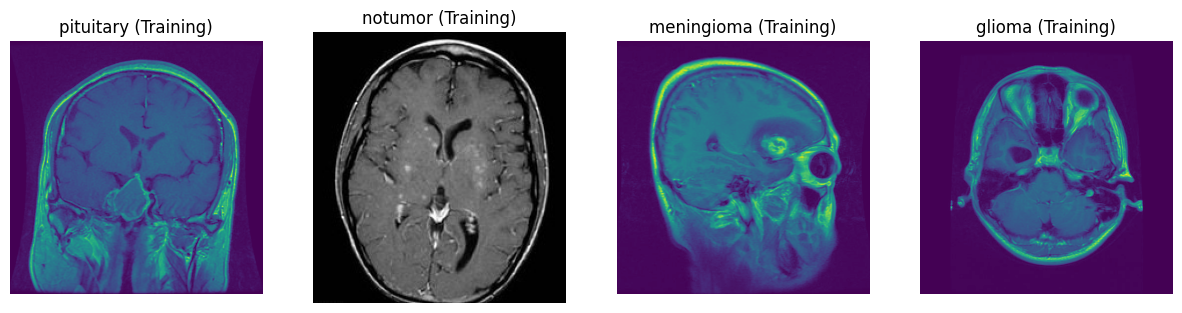

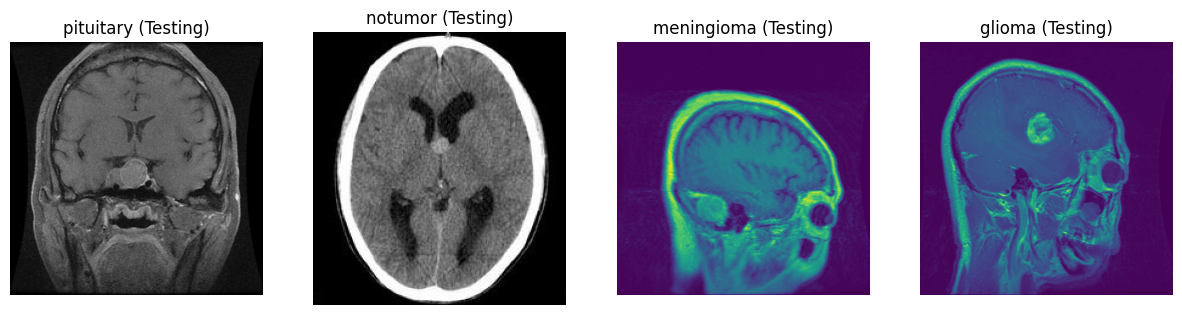

In [4]:
# Definir paths y configuraciones de muestra
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
valid_extensions = ('.jpg', '.jpeg', '.png')
img_size = (150, 150)
batch_size = 32
epochs = 100
seed = 42

# Ejecución de muestra para ver imágenes de cada clase
display_sample_images(train_dir, "Training")
display_sample_images(test_dir, "Testing")

### **Observaciones**

En este primer analisis cualitativo se puede observaar que hay imagenes de distintos tamaños, y de distintos colores, por lo que se realizará un analisis de tamaños.

### **Distribución de clases**

Analizamos la distribución de imágenes en cada clase para identificar posibles desbalances entre las clases

In [5]:
# Función para contar imágenes en cada clase
def count_images(directory):
    label_counts = Counter()
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        valid_files = [f for f in os.listdir(cls_path) if f.endswith(valid_extensions)]
        label_counts[cls] = len(valid_files)
    return label_counts

# Función para graficar la distribución de imágenes por clase
def plot_pie_chart(label_counts, title):
    labels, sizes = label_counts.keys(), label_counts.values()
    colors = sns.color_palette('pastel')[:len(labels)]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.title(title, fontweight='bold')
    plt.show()
    

#### Cantidad de imagenes en el conjunto de entrenamiento

In [6]:
count_images(train_dir)

Counter({'notumor': 1595,
         'pituitary': 1457,
         'meningioma': 1339,
         'glioma': 1321})

#### Cantidad de imagenes en el conjunto de prueba

In [7]:
count_images(test_dir)

Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})

### **Observación general**
Como se puede observar, se cuenta con una buena cantidad de imagenes para entrenar el modelo para fines educativos. No obstante para fines prácticos reales se necesitarían millones de imagenes para lograr hacer generalizar el modelo debido a que existen muchos seres humanos en el mundo, lo que implica variabilidad en la forma y posición de los tumores.

#### Distribución de clases del conjunto de entrenamiento

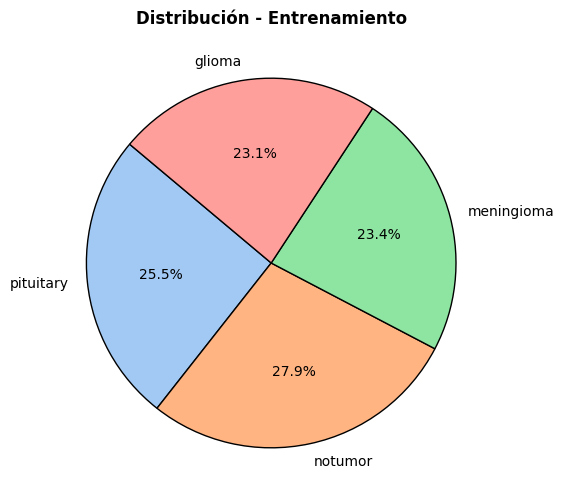

In [8]:
plot_pie_chart(count_images(train_dir), "Distribución - Entrenamiento")


#### Distribución de clases del conjunto de prueba

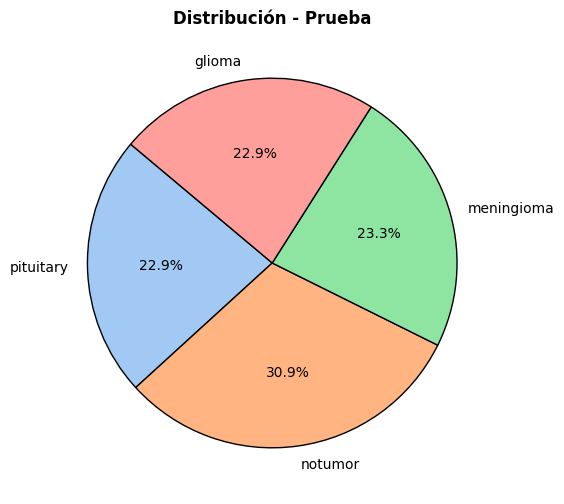

In [9]:
plot_pie_chart(count_images(test_dir), "Distribución - Prueba")

### **Observación general:**

Las clases en ambos conjuntos están balanceadas, lo cual implica que no es necesario realizar ninguna tecnica de balanceo de clases

### **Analisis de tamaños y proporciones de imagenes**
Es importante verificar si las imágenes tienen dimensiones consistentes o si es necesario ajustar sus tamaños.

In [10]:
def analyze_image_sizes(image_directory):
    image_sizes = []
    valid_extensions = ('.jpg', '.jpeg', '.png')

    # Recorre el directorio para recolectar el tamaño de cada imagen
    for root, dirs, files in os.walk(image_directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        image_sizes.append((width, height))
                except Exception as e:
                    print(f"Error al cargar la imagen {file}: {e}")

    if image_sizes:
        widths, heights = zip(*image_sizes)
        aspect_ratios = [width / height for width, height in image_sizes]
        return list(widths), list(heights), aspect_ratios
    else:
        return [], [], []

def compare_image_datasets(train_directory, test_directory):
    # Obtener tamaños y proporciones de aspecto para el conjunto de entrenamiento
    train_widths, train_heights, train_aspect_ratios = analyze_image_sizes(train_directory)

    # Obtener tamaños y proporciones de aspecto para el conjunto de prueba
    test_widths, test_heights, test_aspect_ratios = analyze_image_sizes(test_directory)

    # Gráfico de distribución de anchos de imagen
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(train_widths, bins=30, alpha=0.5, edgecolor='black', label='Entrenamiento')
    plt.hist(test_widths, bins=30, alpha=0.5, edgecolor='black', label='Prueba')
    plt.xlabel('Ancho de Imagen (píxeles)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Anchos de Imagen')
    plt.legend()

    # Gráfico de distribución de altos de imagen
    plt.subplot(1, 2, 2)
    plt.hist(train_heights, bins=30, alpha=0.5, edgecolor='black', label='Entrenamiento')
    plt.hist(test_heights, bins=30, alpha=0.5, edgecolor='black', label='Prueba')
    plt.xlabel('Alto de Imagen (píxeles)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Altos de Imagen')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Distribución de la proporción de aspecto
    plt.figure(figsize=(6, 5))
    plt.hist(train_aspect_ratios, bins=30, alpha=0.5, edgecolor='black', label='Entrenamiento')
    plt.hist(test_aspect_ratios, bins=30, alpha=0.5, edgecolor='black', label='Prueba')
    plt.xlabel('Proporción de Aspecto (Ancho / Alto)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Proporciones de Aspecto de Imagen')
    plt.legend()
    plt.tight_layout()
    plt.show()

### **Comparación de tamaños de imagenes**

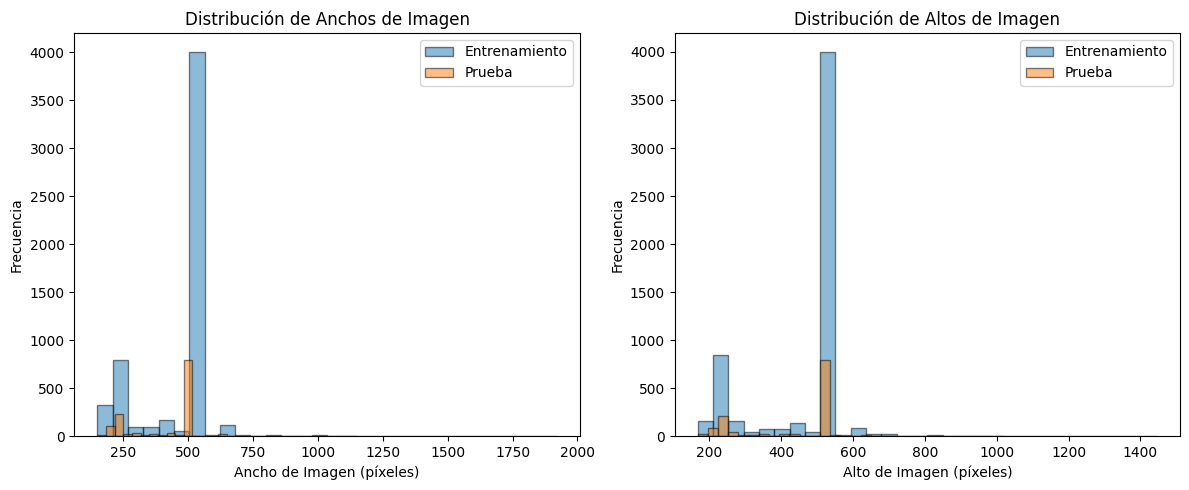

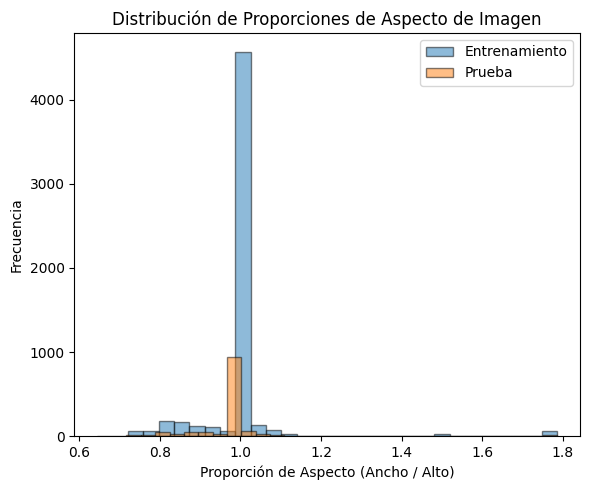

In [11]:
compare_image_datasets('/kaggle/input/brain-tumor-mri-dataset/Training', '/kaggle/input/brain-tumor-mri-dataset/Testing')

### **Análisis de la Distribución de Tamaños de Imagen**

#### **Distribución de Anchos de Imagen**
- El histograma de distribución de anchos muestra la frecuencia de los anchos de las imagenes en pixeles.
- Existe un valor predominante de ancho en **500 píxeles**, que representa la mayoría de las imágenes en ambos conjuntos (entrenamiento y prueba). Este pico en 500 píxeles indica que una gran parte del dataset comparte este ancho específico.

- A pesar de esta concentración en 500 píxeles, hay imágenes con anchos menores y algunos casos dispersos con anchos mayores, lo cual introduce cierta variabilidad en esta dimensión.

#### **Distribución de Altos de Imagen**
- El histograma de distribución de altos muestra la frecuencia de los altos de las imagenes en pixeles.
- Similar al ancho, hay un valor predominante de alto en **500 píxeles** para la mayoría de las imágenes. Esto sugiere una tendencia general en el dataset hacia dimensiones cuadradas o cercanas a serlo.
- Igual que en el caso anterior, hay imágenes con altos menores y algunos casos dispersos con altos mayores, lo cual introduce cierta variabilidad en esta dimensión..

#### **Observaciones Generales sobre la Variabilidad**
- Aunque la mayoría de las imágenes están agrupadas alrededor de los 500 píxeles tanto en ancho como en alto, existe cierta variabilidad en ambas gamas (alto y ancho), lo cual se va a tener que tomar a consideración en el preprocesamiento de las imagenes para el entrenamiento de la red neuronal.

-----



### **Análisis de la distribución de proporciones de aspecto de imagen**

- **Proporción predominante**: El valor predominante de la proporción de aspecto se encuentra alrededor de **1.0**, lo que indica que la mayoría de las imágenes son casi cuadradas, es decir, el ancho y el alto de las imágenes son prácticamente iguales. Este pico es considerablemente alto, lo cual indica que la mayoria de las imagenes del dataset son cuadradas.
  
- **Variabilidad**: A pesar de la concentración alrededor de 1.0, se observan algunas imágenes con proporciones de aspecto distintas, que varían hacia valores menores y mayores que 1.0. Estas imágenes representan casos en los que el ancho y el alto no son iguales, lo que genera una proporción rectangular, ya sea en orientación horizontal o vertical. Sin embargo, estas variaciones son poco frecuentes en comparación con las imágenes cuadradas.

La distribución de proporciones de aspecto es similar en los conjuntos de entrenamiento y prueba. Esto es lo ideal en un set de imagenes, ya que significa que ambos conjuntos tienen características de formato similares, lo cual es deseable para evitar sesgos entre entrenamiento y prueba.

Este análisis sobre la proporción de aspecto es importante para comprender las características geométricas del dataset y anticipar cómo el formato de las imágenes podría influir en el modelo de clasificación.

---

### **Proceso de limpieza y transformación de datos**
- Redimensionamiento de imagenes: Todas las imágenes serán redimensionadas a (150, 150) píxeles. Esto con la intención de lograr que el entrenamiento de la red neuronal fuera más rapida, ya que tamaños de imagenes más grandes hacian que el entrenamiento fuera excesivamente lento. La proporción de las imagenes se conservará con ese tamaño de imagen, mientras que las otras posiblemente verán distorciones no bstante estas distorciones serán muy ligeras debido a que no hay mucha diferencia entre proporciones de aspecto de las imagenes.
- Normalización: Los valores de píxeles serán escalados entre 0 y 1.
- Data Augmentation: Aplicaremos técnicas de aumento de datos para mejorar la generalización del modelo, tales como rotación, desplazamiento, zoom y cambios de brillo.

## **Desarrollo del modelo de deep learning**

### Implementación del modelo
Se decidió utilizar una Red Neuronal Convolucional (CNN) debido a su eficiencia en la clasificación de imagenes.

#### **Carga de datos**

In [12]:
# Bloque 3: Preparación de datos y carga de imágenes para entrenamiento

# Data loader usando ImageDataGenerator
def data_loader(data_dir, img_size, color_mode, batch_size, shuffle, seed, augmentation_params=None):
    if augmentation_params:
        datagen = ImageDataGenerator(
            rescale=augmentation_params.get('rescale', 1.0 / 255),
            rotation_range=augmentation_params.get('rotation_range', 0),
            brightness_range=augmentation_params.get('brightness_range', None),
            width_shift_range=augmentation_params.get('width_shift_range', 0),
            height_shift_range=augmentation_params.get('height_shift_range', 0),
            shear_range=augmentation_params.get('shear_range', 0),
            zoom_range=augmentation_params.get('zoom_range', 0),
            fill_mode=augmentation_params.get('fill_mode', 'nearest'),
            horizontal_flip=augmentation_params.get('horizontal_flip', True),
            vertical_flip=augmentation_params.get('vertical_flip', False)
        )
    else:
        datagen = ImageDataGenerator(rescale=1.0 / 255)

    return datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        seed=seed
    )



### **Justificación de decisiones en la carga y parametros de data augmentation**

* ImageDataGenerator: Permite aplicar data augmentation en tiempo real durante el entrenamiento.
El uso de **data augmentation** permite generar nuevas variaciones de las imágenes originales, lo que mejora la generalización del modelo y reduce el riesgo de sobreajuste, especialmente en datasets pequeños como los de imágenes médicas. A continuación, se justifica la utilidad de cada parámetro en el contexto de imágenes de tumores cerebrales:

---

#### **1. `rescale`**
- **Descripción**: Escala los valores de píxeles de las imágenes de un rango de `[0, 255]` a `[0, 1]`.
- **Justificación**:
  - Normalizar los valores de píxeles mejora la estabilidad del entrenamiento del modelo, ya que evita problemas de gradientes explosivos o atenuados.
  - Este paso es muy importante en imágenes médicas, donde los niveles de intensidad representan información diagnóstica importante.

---

#### **2. `rotation_range`**
- **Descripción**: Rota las imágenes aleatoriamente dentro del rango especificado en grados.
- **Justificación**:
  - En imágenes de tumores cerebrales, la orientación del cerebro puede variar debido a la postura del paciente o al equipo de captura. Este parámetro simula estas variaciones, mejorando la robustez del modelo frente a rotaciones.
  - Ayuda a evitar el sesgo hacia una orientación específica de los tumores.

---

#### **3. `brightness_range`**
- **Descripción**: Ajusta aleatoriamente el brillo de las imágenes dentro del rango especificado.
- **Justificación**:
  - Las imágenes de resonancia magnética pueden tener variaciones en el brillo debido a diferentes configuraciones del escáner o condiciones de captura.
  - Simular estas variaciones mejora la capacidad del modelo para generalizar y reconocer tumores en condiciones de iluminación variadas.

---

#### **4. `width_shift_range` y `height_shift_range`**
- **Descripción**: Desplazan aleatoriamente las imágenes horizontal o verticalmente por una fracción del tamaño de la imagen.
- **Justificación**:
  - En imágenes médicas, el área donde aparece un tumor puede no estar perfectamente centrada debido a las variaciones en la adquisición de imágenes.
  - Este desplazamiento simula dichas inconsistencias, ayudando al modelo a enfocarse en las características importantes en lugar de depender de la posición exacta del tumor.

---

#### **5. `shear_range`**
- **Descripción**: Aplica una transformación de corte, deformando la imagen en una dirección específica.
- **Justificación**:
  - Simula deformaciones que pueden ocurrir debido a la forma del cráneo o sesgos en el equipo de imagenología.
  - Incrementa la diversidad de formas y perspectivas que el modelo puede aprender, haciendo que sea más robusto frente a ligeras distorsiones.

---

#### **6. `zoom_range`**
- **Descripción**: Amplía o reduce aleatoriamente las imágenes dentro del rango especificado.
- **Justificación**:
  - Los tumores pueden variar en tamaño, y el área de interés dentro de las imágenes puede no siempre ocupar el mismo espacio relativo.
  - Este parámetro ayuda al modelo a identificar características relevantes de los tumores independientemente del nivel de zoom.

---

#### **7. `fill_mode`**
- **Descripción**: Determina cómo se rellenan las áreas vacías creadas durante transformaciones como rotaciones, desplazamientos o zoom.
- **Justificación**:
  - El uso de `fill_mode='nearest'` garantiza que las áreas vacías sean rellenadas con valores similares a los píxeles más cercanos, evitando la introducción de patrones artificiales (e.g., bordes negros) que podrían sesgar el aprendizaje del modelo.

---

#### **8. `horizontal_flip`**
- **Descripción**: Invierte las imágenes horizontalmente con una probabilidad del 50%.
- **Justificación**:
  - Aunque el cerebro tiene simetría general, algunos tumores pueden aparecer en distintas regiones (izquierda o derecha). El uso de `horizontal_flip` aumenta la diversidad de datos reflejando esta simetría, ayudando al modelo a reconocer tumores independientemente de su lado.

---

#### **9. `vertical_flip`**
- **Descripción**: Invierte las imágenes verticalmente con una probabilidad del 50%.
- **Justificación**:
  - No se utiliza (`vertical_flip=False`), ya que la orientación vertical del cerebro es fija en las imágenes de resonancia magnética. Aplicar esta transformación podría introducir distorsiones irreales que confundirían al modelo.

---

### **Beneficios Generales de Data Augmentation**
1. **Incremento del dataset efectivo**:
   - Permite simular variaciones realistas sin la necesidad de recolectar más datos, lo cual es especialmente útil en imágenes médicas donde los datasets suelen ser pequeños.
2. **Mejora de la generalización**:
   - Al exponer al modelo a variaciones comunes (rotación, brillo, desplazamiento, etc.), se reducen las probabilidades de sobreajuste.
3. **Simulación de condiciones del mundo real**:
   - Los parámetros seleccionados replican las condiciones y diferencias entre imágenes adquiridas en diferentes entornos clínicos, mejorando la aplicabilidad del modelo.

---

### **Definición de arquitecturas y hiperparámetros**

In [13]:
# Bloque 7: Definición de arquitecturas de modelos
architectures = [
    # Model 1: Based on provided parameters
    {
        'rescale': 1.0 / 255,
        'rotation_range': 20,
        'brightness_range': (0.85, 1.15),
        'width_shift_range': 0.002,
        'height_shift_range': 0.002,
        'shear_range': 12.5,
        'zoom_range': 0,
        'fill_mode': 'nearest',
        'optimizer': 'adam',
        'loss': 'categorical_crossentropy',
        'color_mode': 'rgb',
        'callbacks': [
            EarlyStopping(monitor='accuracy', patience=10, min_delta=1e-9),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5)
        ],
        'layers': [
            {'type': 'Input', 'shape': (150, 150, 3)},
            {'type': 'Conv2D', 'filters': 32, 'kernel_size': (4, 4), 'activation': 'relu'},
            {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
            {'type': 'Conv2D', 'filters': 64, 'kernel_size': (4, 4), 'activation': 'relu'},
            {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
            {'type': 'Conv2D', 'filters': 128, 'kernel_size': (4, 4), 'activation': 'relu'},
            {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
            {'type': 'Flatten'},
            {'type': 'Dense', 'units': 512, 'activation': 'relu'},
            {'type': 'Dropout', 'rate': 0.5},
            {'type': 'Dense', 'units': 4, 'activation': 'softmax'}
        ]
    },
    
    
    # Model 2 (Lightweight)
    {
        'rescale': 1.0 / 255,
        'rotation_range': 25,
        'brightness_range': (0.8, 1.2),
        'width_shift_range': 0.03,
        'height_shift_range': 0.03,
        'shear_range': 12.0,
        'zoom_range': 0.25,
        'fill_mode': 'nearest',
        'optimizer': 'adamw',
        'loss': 'dice',
        'color_mode': 'grayscale',
        'callbacks': [
            EarlyStopping(monitor='loss', patience=10, min_delta=1e-9),
            ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5)
        ],
        'layers': [
            {'type': 'Input', 'shape': (150, 150, 1)},
            {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3), 'activation': 'relu'},
            {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
            {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
            {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
            {'type': 'Flatten'},
            {'type': 'Dense', 'units': 64, 'activation': 'relu'},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Dense', 'units': 4, 'activation': 'softmax'}
        ]
    },
    
    
    # Model 3
    {
    'rescale': 1.0 / 255,
    'rotation_range': 15,
    'brightness_range': (0.9, 1.1),
    'width_shift_range': 0.02,
    'height_shift_range': 0.02,
    'shear_range': 10.0,
    'zoom_range': 0.2,
    'fill_mode': 'nearest',
    'optimizer': 'sgd',  # Using SGD optimizer
    'loss': 'categorical_crossentropy',
    'color_mode': 'rgb',
    'callbacks': [
        EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-9),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 3)},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Conv2D', 'filters': 256, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 256, 'activation': 'relu'},
        {'type': 'Dropout', 'rate': 0.5},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'}
    ]
    },
    
    # Modelo 4 (Basado en el Modelo 1)
{
    'rescale': 1.0 / 255,
    'rotation_range': 20,
    'brightness_range': (0.9, 1.1),  # Se ajustó el rango de brillo del Modelo 1
    'width_shift_range': 0.03,  # Se incrementó el rango de desplazamiento horizontal
    'height_shift_range': 0.03,  # Se incrementó el rango de desplazamiento vertical
    'shear_range': 10.0,  # Se ajustó el rango de corte
    'zoom_range': 0.2,  # Se añadió un rango de zoom
    'fill_mode': 'nearest',
    'optimizer': 'adam',  # Se mantiene el optimizador del Modelo 1
    'loss': 'categorical_crossentropy',
    'color_mode': 'rgb',
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-9),  # Se cambió la paciencia a 10
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5),
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 3)},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},  # Se cambió el tamaño del kernel
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 256, 'activation': 'relu'},  # Se ajustaron las unidades Dense a 256
        {'type': 'Dropout', 'rate': 0.5},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'},
    ],
},

# Modelo 5 (Basado en el Modelo 2)
{
    'rescale': 1.0 / 255,
    'rotation_range': 25,
    'brightness_range': (0.8, 1.2),
    'width_shift_range': 0.02,  # Se ajustó el rango de desplazamiento horizontal
    'height_shift_range': 0.02,  # Se ajustó el rango de desplazamiento vertical
    'shear_range': 12.5,
    'zoom_range': 0.25,
    'fill_mode': 'nearest',
    'optimizer': 'sgd',  # Se cambió el optimizador a SGD
    'loss': 'dice',  # Se mantiene la función de pérdida del Modelo 2
    'color_mode': 'grayscale',
    'callbacks': [
        EarlyStopping(monitor='accuracy', patience=10, min_delta=1e-9),  # Se ajustó la paciencia a 8
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5),
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 1)},
        {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 64, 'activation': 'relu'},
        {'type': 'Dropout', 'rate': 0.3},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'},
    ],
},

# Modelo 6 (Basado en el Modelo 1)
{
    'rescale': 1.0 / 255,
    'rotation_range': 15,
    'brightness_range': (0.85, 1.15),
    'width_shift_range': 0.03,  # Se ajustó el rango de desplazamiento horizontal
    'height_shift_range': 0.03,  # Se ajustó el rango de desplazamiento vertical
    'shear_range': 10.0,
    'zoom_range': 0.2,
    'fill_mode': 'nearest',
    'optimizer': 'adamw',  # Se cambió el optimizador a AdamW
    'loss': 'categorical_crossentropy',
    'color_mode': 'rgb',
    'callbacks': [
        EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-9),  # Se ajustó la paciencia a 6
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 3)},
        {'type': 'Conv2D', 'filters': 64, 'kernel_size': (4, 4), 'activation': 'relu'},  # Se cambió el tamaño del kernel
        {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
        {'type': 'Conv2D', 'filters': 128, 'kernel_size': (4, 4), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 512, 'activation': 'relu'},  # Se mantienen las unidades Dense del Modelo 1
        {'type': 'Dropout', 'rate': 0.5},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'},
    ],
},

# Modelo 7 (Basado en el Modelo 2)
{
    'rescale': 1.0 / 255,
    'rotation_range': 20,
    'brightness_range': (0.9, 1.1),
    'width_shift_range': 0.01,  # Se redujo el rango de desplazamiento horizontal
    'height_shift_range': 0.01,  # Se redujo el rango de desplazamiento vertical
    'shear_range': 12.0,
    'zoom_range': 0,  # Se eliminó el rango de zoom
    'fill_mode': 'nearest',
    'optimizer': 'adamw',
    'loss': 'dice',
    'color_mode': 'grayscale',
    'callbacks': [
        EarlyStopping(monitor='accuracy', patience=10, min_delta=1e-9),  # Se ajustó la paciencia a 7
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5),
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 1)},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 128, 'activation': 'relu'},  # Se incrementaron las unidades Dense a 128
        {'type': 'Dropout', 'rate': 0.5},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'},
    ],
},

# Modelo 8 (Basado en el Modelo 3)
{
    'rescale': 1.0 / 255,
    'rotation_range': 25,
    'brightness_range': (0.8, 1.2),
    'width_shift_range': 0.02,
    'height_shift_range': 0.02,
    'shear_range': 12.5,
    'zoom_range': 0.25,
    'fill_mode': 'nearest',
    'optimizer': 'sgd',
    'loss': 'categorical_crossentropy',
    'color_mode': 'rgb',
    'callbacks': [
        EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-9),  # Se ajustó la paciencia a 10
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6),  # Se ajustó la paciencia a 6
    ],
    'layers': [
        {'type': 'Input', 'shape': (150, 150, 3)},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (4, 4), 'activation': 'relu'},  # Se cambió el tamaño del kernel
        {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
        {'type': 'Conv2D', 'filters': 64, 'kernel_size': (4, 4), 'activation': 'relu'},
        {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
        {'type': 'Flatten'},
        {'type': 'Dense', 'units': 256, 'activation': 'relu'},  # Se ajustaron las unidades Dense a 256
        {'type': 'Dropout', 'rate': 0.5},
        {'type': 'Dense', 'units': 4, 'activation': 'softmax'},
    ],
}
   
]

### **Justificación de hiperparametros**
### **Análisis de los modelos con justificación de valores de aumentación de datos, capas y otros parámetros**

| **Modelo** | **Parámetros de Aumentación de Datos**                                                                                                                                       | **Justificación**                                                                                                                                                                                                                                                                                                                                                                             | **Capas del Modelo**                                                                                                                                                                                                                                          | **Justificación de Capas**                                                                                                                                                                                                                                                                                                                                                                                                          |
|------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Modelo 1 | `rescale`: 1.0 / 255<br>`rotation_range`: 20°<br>`brightness_range`: (0.85, 1.15)<br>`width_shift_range`: 0.002<br>`height_shift_range`: 0.002<br>`shear_range`: 12.5<br>`zoom_range`: 0<br>`fill_mode`: 'nearest'<br>`color_mode`: 'rgb'      | El parámetro `rescale` convierte los valores de los píxeles al rango `[0, 1]`, lo que hace más fácil el entrenamiento del modelo. El `rotation_range` de 20° agrega rotaciones moderadas que simulan pequeñas variaciones en la orientación del cerebro en las imágenes. El `brightness_range` (0.85, 1.15) introduce cambios en la iluminación, ayudando al modelo a manejar distintas condiciones de luz. Los valores pequeños de `width_shift_range` y `height_shift_range` (0.002) simulan desplazamientos ligeros del tumor, manteniendo la coherencia de la imagen. El `shear_range` de 12.5 aplica deformaciones angulares para agregar diversidad al conjunto de datos. Como no se aplica zoom (`zoom_range`: 0), se conserva el tamaño original de los tumores. Finalmente, el `color_mode` 'rgb' aprovecha los colores y texturas de las imágenes para que el modelo pueda aprender más detalles.                       | Tres bloques `Conv2D` con 32, 64 y 128 filtros y `MaxPooling2D`<br>`Dense` con 512 unidades<br>`Dropout` con 0.5<br>`Softmax`<br>`Optimizador`: `adam`<br>`Loss`: `categorical_crossentropy`<br>`Callbacks`: `EarlyStopping`, `ReduceLROnPlateau`                                     | Este modelo usa tres bloques convolucionales que van aumentando el número de filtros, comenzando con los patrones más simples como bordes hasta llegar a características más complejas. La capa densa con 512 unidades permite combinar estas características de manera detallada. El `Dropout` evita que el modelo aprenda detalles irrelevantes, mientras que el optimizador `adam` ajusta automáticamente la velocidad de aprendizaje para estabilizar el entrenamiento. La función de pérdida `categorical_crossentropy` mide qué tan diferentes son las predicciones del modelo y las etiquetas reales, ayudando a ajustar el modelo para problemas de varias clases. Los callbacks detienen el entrenamiento cuando no hay mejoras y ajustan la velocidad de aprendizaje para que el modelo alcance su mejor rendimiento.                    |
| Modelo 2 | `rescale`: 1.0 / 255<br>`rotation_range`: 25°<br>`brightness_range`: (0.8, 1.2)<br>`width_shift_range`: 0.03<br>`height_shift_range`: 0.03<br>`shear_range`: 12.0<br>`zoom_range`: 0.25<br>`fill_mode`: 'nearest'<br>`color_mode`: 'grayscale' | El parámetro `rescale` normaliza los valores de los píxeles en imágenes en escala de grises, reduciendo el impacto de valores muy altos o bajos. El `rotation_range` de 25° agrega más rotaciones para que el modelo pueda aprender patrones independientemente de la orientación del cerebro. El `brightness_range` (0.8, 1.2) introduce cambios en el brillo, importantes para detectar tumores en imágenes donde el contraste es clave. Los desplazamientos `width_shift_range` y `height_shift_range` (0.03) ayudan al modelo a adaptarse a tumores que no están perfectamente centrados. El `shear_range` de 12.0 agrega deformaciones que diversifican el conjunto de datos. El `zoom_range` de 0.25 permite al modelo aprender a reconocer tumores de diferentes tamaños. El `color_mode` 'grayscale' simplifica los datos al centrarse solo en las intensidades, reduciendo la carga computacional.                                              | Dos bloques `Conv2D` con 16 y 32 filtros y `MaxPooling2D`<br>`Dense` con 64 unidades<br>`Dropout` con 0.3<br>`Softmax`<br>`Optimizador`: `adamw`<br>`Loss`: `dice`<br>`Callbacks`: `EarlyStopping`, `ReduceLROnPlateau`                                                                | Este modelo más simple utiliza pocos filtros en los bloques convolucionales para capturar solo las características más importantes. La capa densa con 64 unidades equilibra eficiencia y capacidad de aprendizaje, evitando un modelo demasiado complejo. El `Dropout` regula el modelo para no sobreajustarse al conjunto de entrenamiento. El optimizador `adamw` mejora la generalización al incluir regularización. La función de pérdida `dice` ayuda a manejar posibles desbalances entre clases, permitiendo una mejor diferenciación de tumores. Los callbacks aseguran que el modelo no se entrene de más y ajustan la velocidad de aprendizaje para maximizar su desempeño.        |
| Modelo 3 | `rescale`: 1.0 / 255<br>`rotation_range`: 15°<br>`brightness_range`: (0.9, 1.1)<br>`width_shift_range`: 0.02<br>`height_shift_range`: 0.02<br>`shear_range`: 10.0<br>`zoom_range`: 0.2<br>`fill_mode`: 'nearest'<br>`color_mode`: 'rgb'      | El parámetro `rescale` normaliza los valores de los píxeles para facilitar el entrenamiento del modelo. El `rotation_range` de 15° es más conservador, ya que el modelo profundo tiene suficiente capacidad para aprender sin depender de grandes variaciones en las imágenes. El `brightness_range` (0.9, 1.1) realiza pequeños cambios en la iluminación, asegurando que el modelo no dependa de un nivel de brillo específico. Los desplazamientos `width_shift_range` y `height_shift_range` (0.02) agregan variación moderada mientras mantienen la posición general del tumor. El `shear_range` (10.0) aplica deformaciones ligeras para diversificar las imágenes, y el `zoom_range` de 0.2 introduce pequeñas variaciones de escala, enriqueciendo el conjunto de datos. El `color_mode` 'rgb' permite que el modelo aproveche la textura y el color para aprender características más detalladas.                                     | Cuatro bloques `Conv2D` con 32, 64, 128 y 256 filtros y `MaxPooling2D`<br>`Dense` con 256 unidades<br>`Dropout` con 0.5<br>`Softmax`<br>`Optimizador`: `sgd`<br>`Loss`: `categorical_crossentropy`<br>`Callbacks`: `EarlyStopping`, `ReduceLROnPlateau`                               | Este modelo más complejo utiliza cuatro bloques convolucionales para detectar características avanzadas, desde bordes simples hasta patrones abstractos. La cantidad creciente de filtros en cada bloque asegura que el modelo pueda extraer información más detallada en las capas más profundas. La capa densa con 256 unidades ofrece un buen balance entre capacidad de representación y eficiencia. El `Dropout` reduce el riesgo de que el modelo se sobreajuste al conjunto de entrenamiento. El optimizador `sgd` proporciona un control más preciso del aprendizaje, esencial para modelos grandes, mientras que la función de pérdida `categorical_crossentropy` mide qué tan bien el modelo clasifica las imágenes en las categorías correspondientes. Los callbacks detienen el entrenamiento si no hay mejoras y ajustan la velocidad de aprendizaje para lograr un mejor desempeño. |


---

### **Modelos Combinados**

Los modelos del 4 al 8 se diseñaron a partir de los tres primeros, haciendo combinaciones de sus configuraciones y ajustando hiperparámetros clave. Estos modelos permitieron analizar cómo cambios específicos afectan el desempeño en la clasificación de tumores cerebrales, buscando un equilibrio entre precisión y robustez.

### Modelo 4
Este modelo parte del modelo 1, pero amplía el rango de desplazamientos (`width_shift_range` y `height_shift_range`) e introduce un rango de zoom. Estos cambios buscan evaluar cómo el modelo responde a mayor variabilidad en las imágenes sin comprometer su capacidad de generalización.

### Modelo 5
Derivado del modelo 2, este incorpora el optimizador `sgd` y ajusta los desplazamientos. Estas modificaciones permiten estudiar cómo un modelo más simple responde a un aprendizaje más controlado y a condiciones de datos menos variables.

### Modelo 6
Basado en el modelo 1, pero con un optimizador `adamw` y un rango de zoom. Esto ayuda a analizar si un modelo más profundo con regularización puede manejar datos más diversos y mejorar su capacidad de generalización.

### Modelo 7
Tomando como base el modelo 2, este elimina el zoom y reduce los desplazamientos, buscando que un modelo simple enfoque su aprendizaje en patrones clave en lugar de manejar datos excesivamente variados.

### Modelo 8
Inspirado en el modelo 3, incorpora ajustes en el rango de zoom y el ángulo de deformación (`shear_range`). Esto permite evaluar cómo estas modificaciones ayudan al modelo a captar patrones complejos en datos más variados.

### Objetivo
Estos modelos combinados ayudaron a identificar cómo cada ajuste, como los desplazamientos, el optimizador o el rango de zoom, afecta el rendimiento del modelo.

---

### **Observación**

Los modelos más simples dependen de una mayor diversidad en los datos para aprender, mientras que los modelos más complejos pueden preservar los detalles clave con configuraciones más específicas. Los optimizadores, funciones de pérdida y callbacks garantizan un entrenamiento estable y efectivo para cada arquitectura.

---


### **Entrenamiento de modelos**
Entrenamos cada modelo utilizando la gpu para incrementar la velocidad del codigo y almacenamos los resultados para su posterior análisis.

In [16]:
# Bloque 4: Entrenamiento de múltiples arquitecturas y almacenamiento de resultados

def train_multiple_architectures(architectures, train_dir, test_dir, img_size=(150, 150), batch_size=32, epochs=30, seed=42):
    results = []
    
    for arch_id, arch in enumerate(architectures, 1):
        start_time = time.time()
        train_data = data_loader(
            train_dir, img_size, arch['color_mode'], batch_size, shuffle=True, seed=seed, augmentation_params=arch
        )
        test_data = data_loader(
            test_dir, img_size, arch['color_mode'], batch_size, shuffle=False, seed=seed
        )
        steps_per_epoch = train_data.samples // batch_size
        validation_steps = test_data.samples // batch_size
        
        model = Sequential()
        first_layer = True
        for layer_config in arch['layers']:
            if first_layer:
                model.add(Input(shape=(img_size[0], img_size[1], 3 if arch['color_mode'] == 'rgb' else 1)))
                first_layer = False

            # Add the rest of the layers as usual
            if layer_config['type'] == 'Conv2D':
                model.add(Conv2D(layer_config['filters'], layer_config['kernel_size'], activation=layer_config['activation']))
            elif layer_config['type'] == 'MaxPooling2D':
                model.add(MaxPooling2D(pool_size=layer_config['pool_size']))
            elif layer_config['type'] == 'Dense':
                model.add(Dense(layer_config['units'], activation=layer_config['activation']))
            elif layer_config['type'] == 'Dropout':
                model.add(Dropout(layer_config['rate'], seed=seed))
            elif layer_config['type'] == 'Flatten':
                model.add(Flatten())
        
        optimizer = tf.keras.optimizers.get(arch['optimizer'])
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss=arch['loss'], metrics=['accuracy'])

        callbacks = arch.get('callbacks', [])
        checkpoint_callback = ModelCheckpoint(filepath=f'best_model_arch_{arch_id}.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

        callbacks.append(checkpoint_callback)
        
        print(f"\nTraining architecture ID: {arch_id}")
        
        history = model.fit(
            train_data,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=test_data,
            validation_steps=validation_steps,
            callbacks=callbacks
        )
        
        execution_time = time.time() - start_time
        y_pred, y_true = [], []
        for x_batch, y_batch in test_data:
            y_pred_batch = model.predict(x_batch)
            y_pred.extend(np.argmax(y_pred_batch, axis=1))
            y_true.extend(np.argmax(y_batch, axis=1))
            if len(y_pred) >= len(test_data.classes):
                break
        
        class_names = list(test_data.class_indices.keys())
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

        # Dummy input to initialize the model's input shape
        dummy_input = np.zeros((1, img_size[0], img_size[1], 3 if arch['color_mode'] == 'rgb' else 1))
        model.predict(dummy_input)

        result = {
            'architecture': arch,
            'architecture_id': arch_id,
            'execution_time': execution_time,
            'classification_report': report,
            'model': model,  # Save the trained model
            'history': history.history  # Save training history
        }
        results.append(result)
        
        print(f"\nArchitecture ID: {arch_id}")
        print(f"Execution time: {execution_time:.2f} seconds")
    
    return results

In [17]:
#Bloque 9
# Arquitecturas y entrenamiento
results = train_multiple_architectures(architectures, train_dir, test_dir, img_size, batch_size, epochs, seed)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Training architecture ID: 1
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 255ms/step - accuracy: 0.5326 - loss: 1.0265 - val_accuracy: 0.7430 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7812 - loss: 0.6579

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.6579 - val_accuracy: 0.8710 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.7608 - loss: 0.5792 - val_accuracy: 0.7758 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.9062 - loss: 0.3075 - val_accuracy: 0.9677 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.8232 - loss: 0.4589 - val_accuracy: 0.7945 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.8750 - loss: 0.3285 - val_accuracy: 0.9677 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.8669 - loss: 0.3700 - val_accuracy: 0.8539 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.4465 - loss: 0.5633 - val_accuracy: 0.6383 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6250 - loss: 0.4263

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 0.4263 - val_accuracy: 0.9677 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.6016 - loss: 0.4037 - val_accuracy: 0.6602 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.5938 - loss: 0.4300 - val_accuracy: 0.9677 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.6255 - loss: 0.3804 - val_accuracy: 0.6602 - val_loss: 0.3424 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.2927 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6413 - loss: 0.3638 - val_accuracy: 0.5977 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7188 - loss: 0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step

Architecture ID: 2
Execution time: 313.63 seconds
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Training architecture ID: 3
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.2926 - loss: 1.3467 - val_accuracy: 0.4688 - val_loss: 1.2005 - learning_rate: 0.0100
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5312 - loss: 1.3070

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5312 - loss: 1.3070 - val_accuracy: 1.0000 - val_loss: 1.0053 - learning_rate: 0.0100
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.5606 - loss: 1.0921 - val_accuracy: 0.6016 - val_loss: 1.0764 - learning_rate: 0.0100
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.7812 - loss: 0.8587 - val_accuracy: 0.9677 - val_loss: 0.5872 - learning_rate: 0.0100
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.6238 - loss: 0.9425 - val_accuracy: 0.6203 - val_loss: 1.0472 - learning_rate: 0.0100
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6562 - loss: 1.0643 - val_accuracy: 0.9677 - val_loss: 0.4992 - learning_rate: 0.0100
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.6402 - loss: 0.9004 - val_accuracy: 0.6383 - val_loss: 1.0298 - learning_rate: 0.0100
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.6250 - loss:

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step - accuracy: 0.4109 - loss: 2.2279 - val_accuracy: 0.7437 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6562 - loss: 0.8160

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6562 - loss: 0.8160 - val_accuracy: 1.0000 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - accuracy: 0.7034 - loss: 0.7313 - val_accuracy: 0.6352 - val_loss: 1.0092 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.8125 - loss: 0.4710 - val_accuracy: 0.7742 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.7425 - loss: 0.6333 - val_accuracy: 0.6273 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.8125 - loss: 0.5355 - val_accuracy: 0.8065 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.7734 - loss: 0.5807 - val_accuracy: 0.6883 - val_loss: 0.9172 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7500 - loss:

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.2802 - loss: 0.7112 - val_accuracy: 0.3164 - val_loss: 0.6610 - learning_rate: 0.0100
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 0.6669 - val_accuracy: 0.0000e+00 - val_loss: 0.8109 - learning_rate: 0.0100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.2700 - loss: 0.6747 - val_accuracy: 0.3469 - val_loss: 0.6198 - learning_rate: 0.0100
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.4062 - loss: 0.6228 - val_accuracy: 0.1935 - val_loss: 0.6292 - learning_rate: 0.0100
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.4343 - loss: 0.6140 - val_accuracy: 0.6141 - val_loss: 0.4897 - learning_rate: 0.0100
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.5625 - loss: 0.5246 - val_accuracy: 0.8065 - val_loss: 0.3619 - learning_rate: 0.0100
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5455 - loss: 0.5074 - val_accuracy: 0.6125 - val_loss: 0.4209 - learning_rate: 0.0100
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.4375 - loss: 0.5456 - val_accuracy: 1.0000 - val_loss: 0.0615 - learning_rate: 0.0100
Epoch 9/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step - accuracy: 0.4450 - loss: 1.4606 - val_accuracy: 0.6391 - val_loss: 1.1053 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6875 - loss: 0.7085

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6875 - loss: 0.7085 - val_accuracy: 0.9677 - val_loss: 0.2823 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.7025 - loss: 0.7210 - val_accuracy: 0.7297 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.5938 - loss: 0.7645 - val_accuracy: 0.9677 - val_loss: 0.3042 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.7659 - loss: 0.5996 - val_accuracy: 0.7586 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.6118 - val_accuracy: 0.8710 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.7883 - loss: 0.5186 - val_accuracy: 0.7672 - val_loss: 0.6460 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.8750 - loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.3404 - loss: 0.6620 - val_accuracy: 0.5891 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5000 - loss: 0.5196

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5000 - loss: 0.5196 - val_accuracy: 0.8710 - val_loss: 0.1404 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.6491 - loss: 0.3586 - val_accuracy: 0.6266 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6875 - loss: 0.3231 - val_accuracy: 1.0000 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6595 - loss: 0.3471 - val_accuracy: 0.6281 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.7188 - loss: 0.2882 - val_accuracy: 0.9032 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.6715 - loss: 0.3341 - val_accuracy: 0.6406 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7500 - loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.3582 - loss: 1.2942 - val_accuracy: 0.6297 - val_loss: 1.0548 - learning_rate: 0.0100
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4688 - loss: 1.1311

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.1311 - val_accuracy: 0.8710 - val_loss: 0.8658 - learning_rate: 0.0100
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.5436 - loss: 1.0808 - val_accuracy: 0.6086 - val_loss: 0.9908 - learning_rate: 0.0100
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.5938 - loss: 0.9370 - val_accuracy: 0.9355 - val_loss: 0.6244 - learning_rate: 0.0100
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.6040 - loss: 0.9530 - val_accuracy: 0.6789 - val_loss: 0.8859 - learning_rate: 0.0100
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7500 - loss: 0.7528 - val_accuracy: 0.9355 - val_loss: 0.5731 - learning_rate: 0.0100
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.6303 - loss: 0.8861 - val_accuracy: 0.6586 - val_loss: 0.8800 - learning_rate: 0.0100
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.6250 - loss:

## **Resultados e interpretación**

Estas funciones son las que utilizaremos para evaluar el desempeño de los modelos en terminos de recall, precision y tiempo de ejecución. También se mostrará la arquitectura del modelo para saber identificar de mejor manera cual es la red que se esta analizando.

In [25]:
# Bloque 10
# Visualización de métricas
def mostrar_detalles_arquitectura(result):
    
    print("\nArquitectura de la Red Neuronal:")
    table_architecture = PrettyTable()
    table_architecture.field_names = ["Capa", "Detalles"]
    for i, layer in enumerate(result['architecture']['layers'], 1):
        layer_type = layer.get('type')
        details = ', '.join([f"{k}={v}" for k, v in layer.items() if k != 'type'])
        table_architecture.add_row([f"{i}. {layer_type}", details])
    print(table_architecture)

def plot_training_history(history, arch_id):
    epochs = range(1, len(history['accuracy']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Precisión Entrenamiento')
    plt.plot(epochs, history['val_accuracy'], label='Precisión Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title(f'Arquitectura {arch_id} - Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Pérdida Entrenamiento')
    plt.plot(epochs, history['val_loss'], label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'Arquitectura {arch_id} - Pérdida')
    plt.legend()
    plt.tight_layout()
    plt.show()

Modelo:  1

Arquitectura de la Red Neuronal:
+-----------------+--------------------------------------------------+
|       Capa      |                     Detalles                     |
+-----------------+--------------------------------------------------+
|     1. Input    |               shape=(150, 150, 3)                |
|    2. Conv2D    | filters=32, kernel_size=(4, 4), activation=relu  |
| 3. MaxPooling2D |                 pool_size=(3, 3)                 |
|    4. Conv2D    | filters=64, kernel_size=(4, 4), activation=relu  |
| 5. MaxPooling2D |                 pool_size=(3, 3)                 |
|    6. Conv2D    | filters=128, kernel_size=(4, 4), activation=relu |
| 7. MaxPooling2D |                 pool_size=(3, 3)                 |
|    8. Flatten   |                                                  |
|     9. Dense    |            units=512, activation=relu            |
|   10. Dropout   |                     rate=0.5                     |
|    11. Dense    |           un

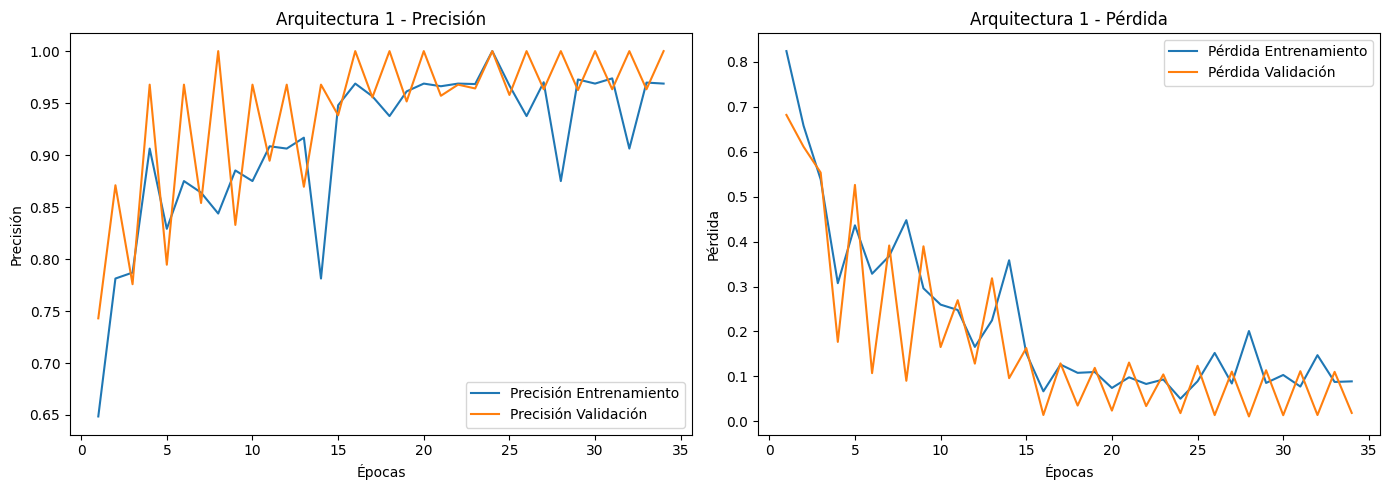

Modelo:  2

Arquitectura de la Red Neuronal:
+-----------------+-------------------------------------------------+
|       Capa      |                     Detalles                    |
+-----------------+-------------------------------------------------+
|     1. Input    |               shape=(150, 150, 1)               |
|    2. Conv2D    | filters=16, kernel_size=(3, 3), activation=relu |
| 3. MaxPooling2D |                 pool_size=(2, 2)                |
|    4. Conv2D    | filters=32, kernel_size=(3, 3), activation=relu |
| 5. MaxPooling2D |                 pool_size=(2, 2)                |
|    6. Flatten   |                                                 |
|     7. Dense    |            units=64, activation=relu            |
|    8. Dropout   |                     rate=0.3                    |
|     9. Dense    |           units=4, activation=softmax           |
+-----------------+-------------------------------------------------+

Gráficas de precisión y pérdida en el set de

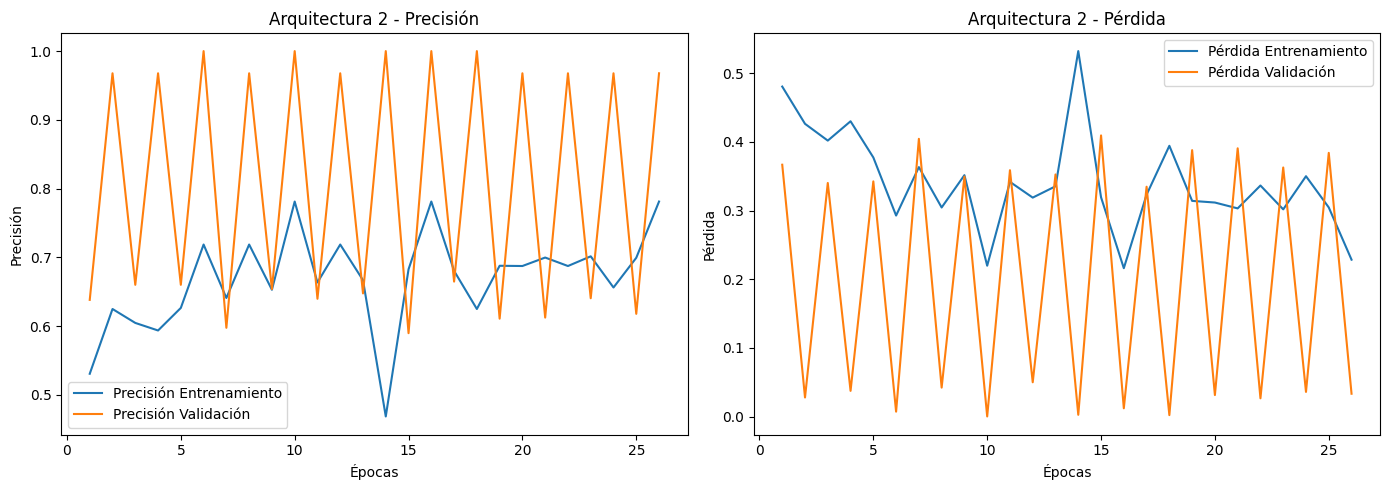

Modelo:  3

Arquitectura de la Red Neuronal:
+-----------------+--------------------------------------------------+
|       Capa      |                     Detalles                     |
+-----------------+--------------------------------------------------+
|     1. Input    |               shape=(150, 150, 3)                |
|    2. Conv2D    | filters=32, kernel_size=(3, 3), activation=relu  |
| 3. MaxPooling2D |                 pool_size=(2, 2)                 |
|    4. Conv2D    | filters=64, kernel_size=(3, 3), activation=relu  |
| 5. MaxPooling2D |                 pool_size=(2, 2)                 |
|    6. Conv2D    | filters=128, kernel_size=(3, 3), activation=relu |
| 7. MaxPooling2D |                 pool_size=(2, 2)                 |
|    8. Conv2D    | filters=256, kernel_size=(3, 3), activation=relu |
| 9. MaxPooling2D |                 pool_size=(2, 2)                 |
|   10. Flatten   |                                                  |
|    11. Dense    |            u

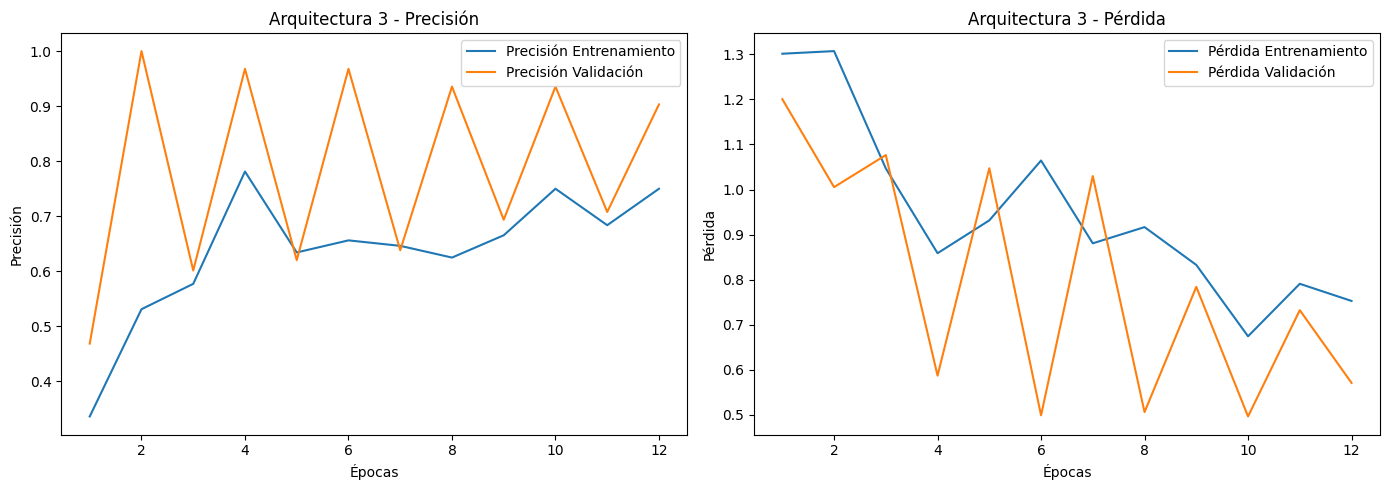

Modelo:  4

Arquitectura de la Red Neuronal:
+-----------------+-------------------------------------------------+
|       Capa      |                     Detalles                    |
+-----------------+-------------------------------------------------+
|     1. Input    |               shape=(150, 150, 3)               |
|    2. Conv2D    | filters=32, kernel_size=(3, 3), activation=relu |
| 3. MaxPooling2D |                 pool_size=(2, 2)                |
|    4. Conv2D    | filters=64, kernel_size=(3, 3), activation=relu |
| 5. MaxPooling2D |                 pool_size=(2, 2)                |
|    6. Flatten   |                                                 |
|     7. Dense    |            units=256, activation=relu           |
|    8. Dropout   |                     rate=0.5                    |
|     9. Dense    |           units=4, activation=softmax           |
+-----------------+-------------------------------------------------+

Gráficas de precisión y pérdida en el set de

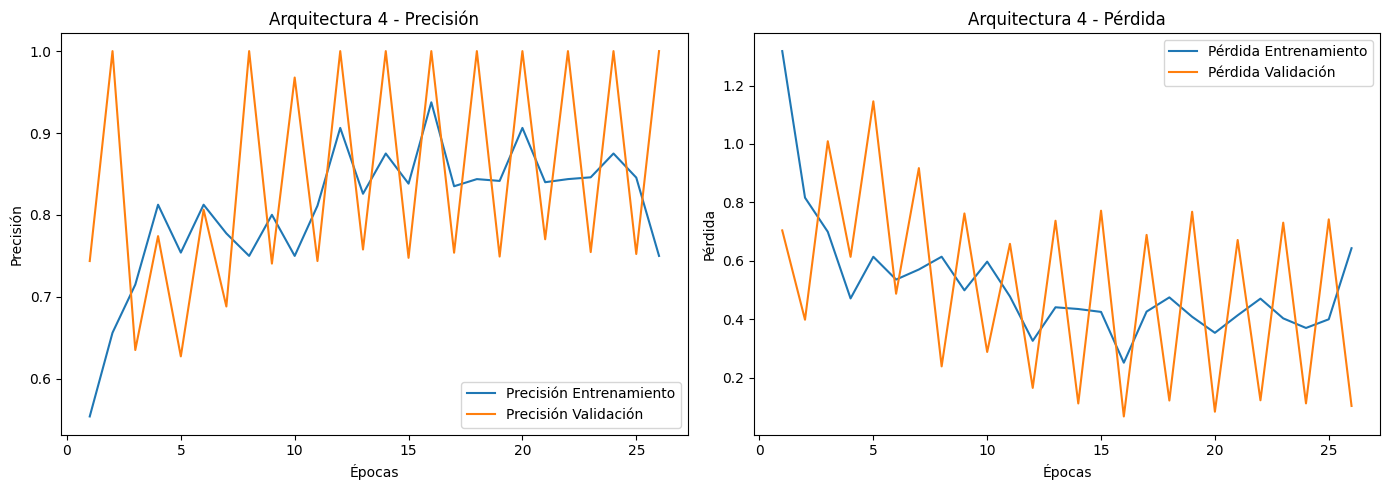

Modelo:  5

Arquitectura de la Red Neuronal:
+-----------------+-------------------------------------------------+
|       Capa      |                     Detalles                    |
+-----------------+-------------------------------------------------+
|     1. Input    |               shape=(150, 150, 1)               |
|    2. Conv2D    | filters=16, kernel_size=(3, 3), activation=relu |
| 3. MaxPooling2D |                 pool_size=(2, 2)                |
|    4. Conv2D    | filters=32, kernel_size=(3, 3), activation=relu |
| 5. MaxPooling2D |                 pool_size=(2, 2)                |
|    6. Flatten   |                                                 |
|     7. Dense    |            units=64, activation=relu            |
|    8. Dropout   |                     rate=0.3                    |
|     9. Dense    |           units=4, activation=softmax           |
+-----------------+-------------------------------------------------+

Gráficas de precisión y pérdida en el set de

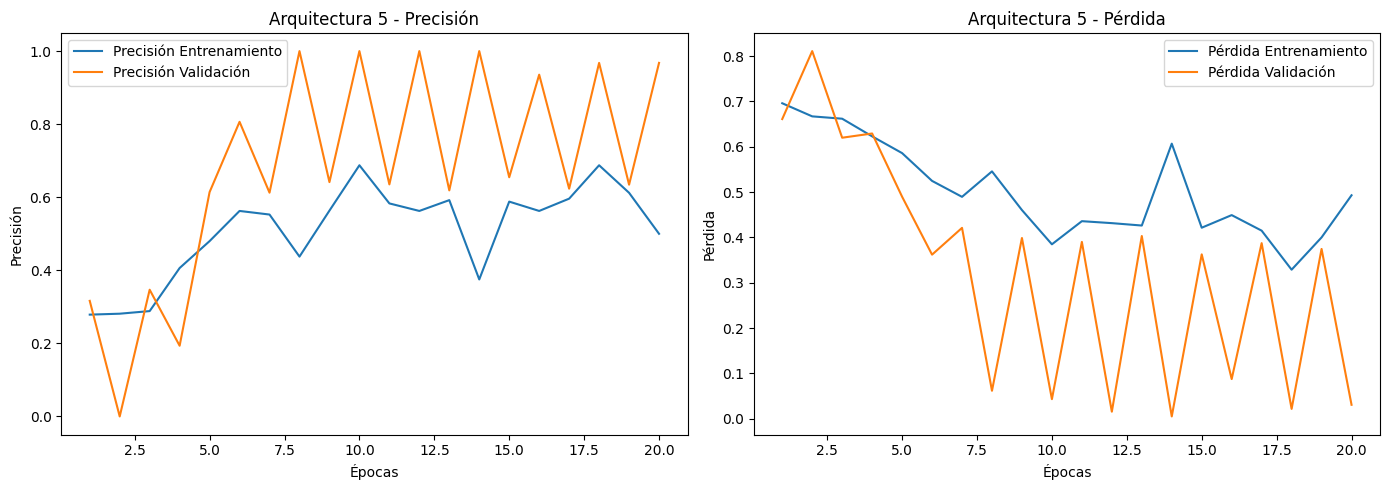

Modelo:  6

Arquitectura de la Red Neuronal:
+-----------------+--------------------------------------------------+
|       Capa      |                     Detalles                     |
+-----------------+--------------------------------------------------+
|     1. Input    |               shape=(150, 150, 3)                |
|    2. Conv2D    | filters=64, kernel_size=(4, 4), activation=relu  |
| 3. MaxPooling2D |                 pool_size=(3, 3)                 |
|    4. Conv2D    | filters=128, kernel_size=(4, 4), activation=relu |
| 5. MaxPooling2D |                 pool_size=(3, 3)                 |
|    6. Flatten   |                                                  |
|     7. Dense    |            units=512, activation=relu            |
|    8. Dropout   |                     rate=0.5                     |
|     9. Dense    |           units=4, activation=softmax            |
+-----------------+--------------------------------------------------+

Gráficas de precisión y pérdida

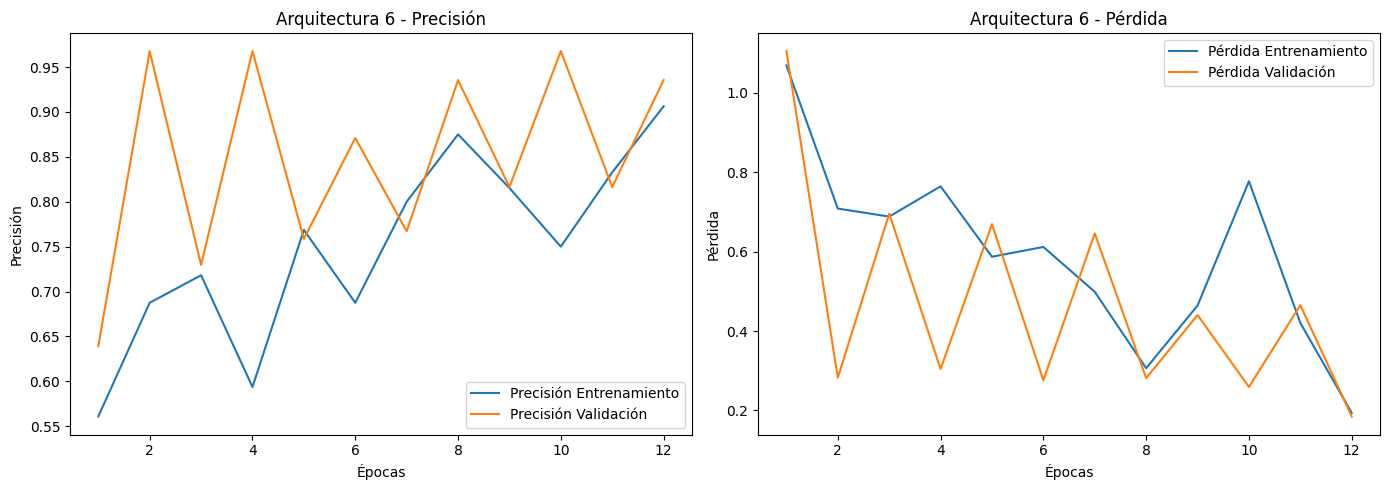

Modelo:  7

Arquitectura de la Red Neuronal:
+-----------------+-------------------------------------------------+
|       Capa      |                     Detalles                    |
+-----------------+-------------------------------------------------+
|     1. Input    |               shape=(150, 150, 1)               |
|    2. Conv2D    | filters=32, kernel_size=(3, 3), activation=relu |
| 3. MaxPooling2D |                 pool_size=(2, 2)                |
|    4. Flatten   |                                                 |
|     5. Dense    |            units=128, activation=relu           |
|    6. Dropout   |                     rate=0.5                    |
|     7. Dense    |           units=4, activation=softmax           |
+-----------------+-------------------------------------------------+

Gráficas de precisión y pérdida en el set de entrenamiento y prueba:



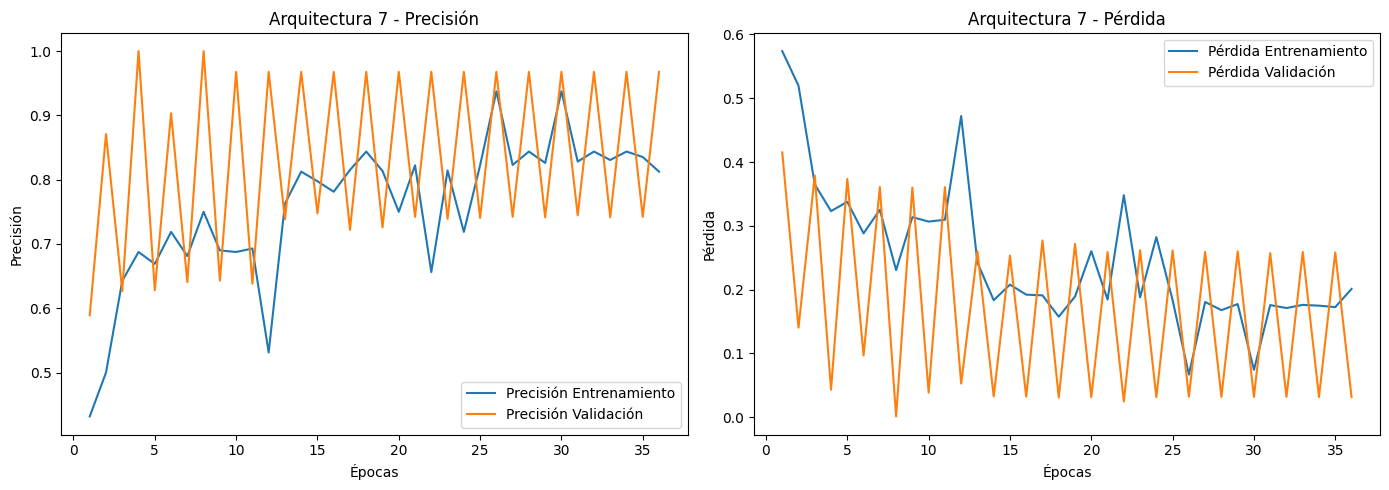

Modelo:  8

Arquitectura de la Red Neuronal:
+-----------------+-------------------------------------------------+
|       Capa      |                     Detalles                    |
+-----------------+-------------------------------------------------+
|     1. Input    |               shape=(150, 150, 3)               |
|    2. Conv2D    | filters=32, kernel_size=(4, 4), activation=relu |
| 3. MaxPooling2D |                 pool_size=(3, 3)                |
|    4. Conv2D    | filters=64, kernel_size=(4, 4), activation=relu |
| 5. MaxPooling2D |                 pool_size=(3, 3)                |
|    6. Flatten   |                                                 |
|     7. Dense    |            units=256, activation=relu           |
|    8. Dropout   |                     rate=0.5                    |
|     9. Dense    |           units=4, activation=softmax           |
+-----------------+-------------------------------------------------+

Gráficas de precisión y pérdida en el set de

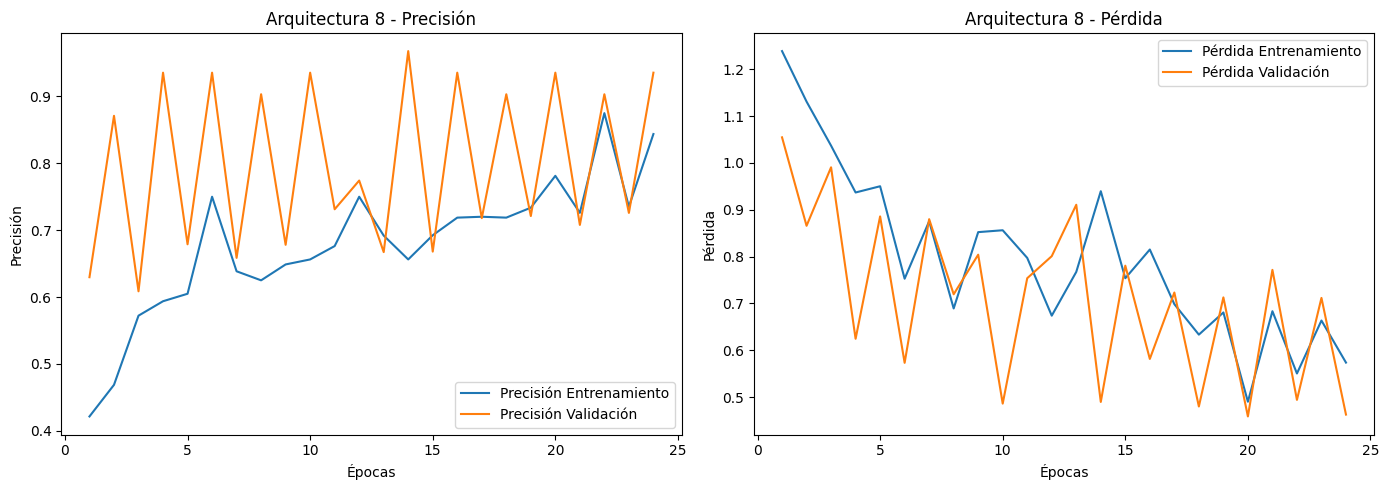

In [27]:
for result in results:
    print('Modelo: ',result['architecture_id'])
    mostrar_detalles_arquitectura(result)
    print('\nGráficas de precisión y pérdida en el set de entrenamiento y prueba:\n')
    plot_training_history(result['history'], result['architecture_id']) 

### **Análisis de las gráficas de precisión y pérdida por modelo**

Cada gráfico muestra cómo evolucionan la precisión y la pérdida tanto en el entrenamiento como en la validación a lo largo de las épocas. Estas métricas nos permiten identificar si el modelo está aprendiendo correctamente, si hay problemas de sobreajuste (cuando el modelo aprende demasiado de los datos de entrenamiento) o subentrenamiento (cuando el modelo no logra capturar patrones clave). A continuación, se analiza el comportamiento de cada modelo.

---

#### **Arquitectura 1**
- **Precisión:** La precisión de entrenamiento y validación convergen hacia valores altos (95%-100%), mostrando que el modelo está aprendiendo de manera estable y generalizando bien. Las curvas son consistentes y no presentan oscilaciones significativas.
- **Pérdida:** La pérdida de entrenamiento y validación disminuyen de forma similar, lo que sugiere que el modelo no tiene problemas de sobreajuste ni subentrenamiento. Este modelo tiene un buen balance entre su capacidad y los datos utilizados.

#### **Arquitectura 2**
- **Precisión:** La precisión de validación fluctúa mucho, pero siempre está por encima de la precisión de entrenamiento. Esto puede indicar que las transformaciones de datos (como aumentación) benefician al modelo en validación, pero el entrenamiento aún no es estable.
- **Pérdida:** La pérdida de validación también fluctúa, pero está consistentemente por debajo de la pérdida de entrenamiento. Esto sugiere que el modelo no está sobreajustándose, aunque las oscilaciones muestran inestabilidad en el aprendizaje.

#### **Arquitectura 3**
- **Precisión:** La precisión de validación también fluctúa por encima de la precisión de entrenamiento, indicando un comportamiento similar al del modelo 2. Sin embargo, las oscilaciones son mayores, lo que podría ser un indicador de que la arquitectura no es lo suficientemente robusta para manejar los datos.
- **Pérdida:** La pérdida de validación fluctúa por debajo de la pérdida de entrenamiento, lo que refuerza la idea de que el modelo no está sobreajustándose, pero las grandes variaciones indican problemas de estabilidad.

#### **Arquitectura 4**
- **Precisión:** La precisión de validación y entrenamiento oscilan de manera similar y sus curvas se solapan. Aunque esto podría parecer un buen indicador, las oscilaciones muestran que el modelo no está aprendiendo de forma estable. Este comportamiento refleja inestabilidad en el aprendizaje.
- **Pérdida:** La pérdida de validación fluctúa alrededor de la pérdida de entrenamiento. El early stopping detuvo el entrenamiento al no observarse mejoras significativas en la validación, lo que evitó un sobreentrenamiento, pero no solucionó el problema subyacente de inestabilidad. Esto sugiere que el modelo requiere ajustes en la arquitectura o en los hiperparámetros.

#### **Arquitectura 5**
- **Precisión:** La precisión de validación fluctúa por encima de la precisión de entrenamiento, mostrando que el modelo puede aprender patrones en validación que no están presentes de forma consistente en el entrenamiento. Sin embargo, las oscilaciones indican que el aprendizaje no es completamente estable.
- **Pérdida:** La pérdida de validación fluctúa por debajo de la pérdida de entrenamiento, lo que indica que el modelo está manejando bien los datos de validación, aunque aún necesita ajustes para reducir las oscilaciones.

#### **Arquitectura 6**
- **Precisión:** La precisión de validación fluctúa mucho, pero se mantiene por encima de la precisión de entrenamiento. Esto sugiere que el modelo está aprendiendo, pero no logra estabilizar su rendimiento debido a las variaciones en los datos o la configuración de los hiperparámetros.
- **Pérdida:** La pérdida de validación fluctúa por debajo de la pérdida de entrenamiento, lo que indica que el modelo no está sobreajustándose, pero la falta de estabilidad en las curvas refleja problemas en la consistencia del aprendizaje.

#### **Arquitectura 7**
- **Precisión:** La precisión de validación presenta grandes oscilaciones, pero está consistentemente por encima de la precisión de entrenamiento. Esto puede deberse a que las técnicas de transformación de datos están ayudando al modelo en validación, pero el entrenamiento aún no es completamente estable.
- **Pérdida:** La pérdida de validación fluctúa por debajo de la pérdida de entrenamiento, reforzando la idea de que el modelo no está sobreajustándose, pero las oscilaciones significan que necesita ajustes para mejorar su estabilidad.

#### **Arquitectura 8**
- **Precisión:** La precisión de validación fluctúa por encima de la precisión de entrenamiento, mostrando patrones similares a los modelos 2, 3, 5, 6 y 7. Esto puede indicar que el modelo está aprendiendo características específicas del conjunto de validación, pero aún le falta estabilidad.
- **Pérdida:** La pérdida de validación fluctúa por debajo de la pérdida de entrenamiento, sugiriendo que el modelo no está sobreajustándose, aunque las grandes oscilaciones reflejan que el aprendizaje sigue siendo inconsistente.

---

### **Observaciones**
1. **Mejor modelo:** La arquitectura 1 es la más estable y presenta un buen balance entre las métricas de entrenamiento y validación. Sus curvas muestran que el modelo está aprendiendo de manera consistente, sin fluctuaciones significativas ni indicios de sobreajuste o subentrenamiento. Esto sugiere que la arquitectura y los hiperparámetros están bien ajustados para este conjunto de datos.
2. **Inestabilidad en otros modelos:** Las arquitecturas 2, 3, 5, 6, 7 y 8 tienen patrones en los que la precisión de validación supera a la de entrenamiento, y la pérdida de validación está por debajo de la de entrenamiento. Aunque esto indica que no están sobreajustándose, las fluctuaciones reflejan inestabilidad en el aprendizaje.
4. **Impacto del early stopping:** Este mecanismo fue clave para detener el entrenamiento en modelos inestables, evitando un sobreajuste innecesario. Sin embargo, las oscilaciones en varias arquitecturas sugieren que los hiperparámetros o las configuraciones deben ser refinados para lograr una mayor estabilidad y consistencia en el aprendizaje.


In [28]:
 # Visualización de métricas
accuracy_data = []
recall_data = []
execution_times = []

for result in results:
    
    # Extraer precisión, recall y tiempo de ejecución por modelo
    model_id = result['architecture_id']
    classification_report = result['classification_report']
    execution_time = result['execution_time']  # Tiempo de ejecución del modelo
    
    # Guardar datos de precisión y recall por clase
    model_accuracy = {"Modelo": model_id}
    model_recall = {"Modelo": model_id}
    
    for clase, metricas in classification_report.items():
        if clase not in ["accuracy", "macro avg", "weighted avg"]:
            model_accuracy[clase] = metricas['precision']
            model_recall[clase] = metricas['recall']
    
    # Agregar datos a las listas correspondientes
    accuracy_data.append(model_accuracy)
    recall_data.append(model_recall)
    execution_times.append({"Modelo": model_id, "Tiempo de Ejecución (s)": execution_time})

# Crear DataFrames para las tablas
df_accuracy = pd.DataFrame(accuracy_data).set_index("Modelo")
df_recall = pd.DataFrame(recall_data).set_index("Modelo")
df_execution = pd.DataFrame(execution_times).set_index("Modelo")

# Mostrar tablas
print("\nTabla de Precisión por Modelo y Clase:")
display(df_accuracy)

print("\nTabla de Recall por Modelo y Clase:")
display(df_recall)

print("\nTabla de Tiempos de Ejecución:")
display(df_execution)


Tabla de Precisión por Modelo y Clase:


glioma  meningioma   notumor  pituitary
Modelo                                           
1       0.989362    0.933775  0.955189   0.986799
2       0.625000    0.000000  0.702988   0.542471
3       0.633245    0.565517  0.766440   0.783237
4       0.929412    0.674641  0.761364   0.722772
5       0.623853    0.524096  0.774105   0.615385
6       0.867424    0.688073  0.812121   0.880240
7       0.940741    0.517241  0.775391   0.843478
8       0.820513    0.595455  0.799574   0.683841


Tabla de Recall por Modelo y Clase:


glioma  meningioma   notumor  pituitary
Modelo                                           
1       0.930000    0.921569  1.000000   0.996667
2       0.466667    0.000000  0.987654   0.936667
3       0.800000    0.267974  0.834568   0.903333
4       0.526667    0.460784  0.992593   0.973333
5       0.680000    0.284314  0.693827   0.933333
6       0.763333    0.490196  0.992593   0.980000
7       0.423333    0.539216  0.980247   0.970000
8       0.533333    0.428105  0.925926   0.973333


Tabla de Tiempos de Ejecución:


Tiempo de Ejecución (s)
Modelo                         
1                    790.040195
2                    313.634308
3                    275.583696
4                    603.270469
5                    241.768980
6                    280.656225
7                    437.437828
8                    609.162562

### **Identificación y justificación de los mejores parámetros**

Para determinar los mejores parámetros de arquitectura y data augmentation en la clasificación de tumores cerebrales, se analizaron los ocho modelos considerando métricas como recall, tiempo de ejecución y las observaciones obtenidas de las gráficas de precisión y pérdida durante el entrenamiento y validación. El enfoque principal fue minimizar los falsos negativos, por lo que la metrica principal es recall, ya que en el contexto médico es crucial identificar correctamente los tumores para evitar diagnósticos erróneos o tardíos.

---

### **Resultados e Interpretación**

Los modelos que lograron los mejores resultados fueron el **modelo 1** y el **modelo 6**, destacando el **modelo 1** como el más efectivo debido a su mayor estabilidad y capacidad para minimizar errores graves (falsos negativos).

---

### **Comparación de Diferentes Parámetros**

#### **Optimizador y Función de Pérdida**
- **Modelo 1:**
  - Optimiza con Adam y utiliza `categorical_crossentropy`.
  - Tiempo de ejecución: **790.04 segundos**.
- **Modelo 6:**
  - Utiliza AdamW como optimizador y también `categorical_crossentropy`.
  - Tiempo de ejecución: **280.66 segundos**.

**Observaciones:**
- Ambos modelos usan `categorical_crossentropy`, una función adecuada para problemas de clasificación multiclase.
- El optimizador Adam en el modelo 1 permitió un aprendizaje más estable y un mejor recall en comparación con AdamW en el modelo 6.
- El modelo 1 tiene un tiempo de ejecución mayor debido a su arquitectura más compleja y procesos adicionales.

**Justificación:**
- Adam facilita un aprendizaje adaptativo y estable, maximizando el recall y asegurando que los tumores se clasifiquen correctamente, reduciendo así los falsos negativos.
- Aunque el tiempo de ejecución del modelo 1 es mayor, su rendimiento en la clasificación precisa de tumores lo justifica, ya que en el ámbito médico la prioridad es la exactitud más que la velocidad.

---

#### **Parámetros de Transformaciones de Datos**
- **Modelo 1:** 
  - `rotation_range`: 20°, `brightness_range`: (0.85, 1.15), `shear_range`: 12.5, sin zoom.
  - Tiempo de ejecución: **790.04 segundos**.
- **Modelo 6:** 
  - `rotation_range`: 15°, `brightness_range`: (0.85, 1.15), `shear_range`: 10.0, `zoom_range`: 0.2.
  - Tiempo de ejecución: **280.66 segundos**.

**Observaciones:**
- Un rango de rotación moderado (15°-20°) y un brillo controlado (0.85-1.15) favorecen la generalización sin alterar la estructura del tumor.
- El modelo 1 evita el zoom, preservando las proporciones originales de los tumores, mientras que el modelo 6 utiliza un zoom moderado para agregar diversidad.
- El mayor shear_range del modelo 1 introduce deformaciones que fortalecen su capacidad de generalización sin afectar el reconocimiento de patrones clave.

**Justificación:**
- Estas configuraciones permiten al modelo 1 reconocer mejor las variaciones reales en los datos, lo que contribuye a minimizar errores críticos (falsos negativos). Aunque implica mayor tiempo de ejecución, este se ve compensado por su precisión en escenarios médicos.

---

#### **Arquitectura del Modelo**
- **modelo 1:** Tres capas convolucionales con 32, 64 y 128 filtros; tamaño de kernel (4, 4); una capa densa de 512 unidades.
  - Tiempo de ejecución: **790.04 segundos**.
- **modelo 6:** Dos capas convolucionales con 64 y 128 filtros; tamaño de kernel (4, 4); una capa densa de 512 unidades.
  - Tiempo de ejecución: **280.66 segundos**.

**Observaciones:**
- El modelo 1 incluye una capa convolucional adicional, lo que permite capturar características más detalladas y complejas.
- Ambos modelos tienen capas densas robustas que ayudan a identificar combinaciones avanzadas de características relevantes.

**Justificación:**
- La arquitectura más profunda del modelo 1 mejora la extracción de patrones jerárquicos, desde bordes simples hasta características más complejas, lo que es esencial para distinguir entre tipos de tumores. Aunque requiere mayor tiempo de ejecución, esto es aceptable en un contexto clínico donde se prioriza minimizar falsos negativos.

---

#### **Uso de Dropout y Regularización**
- Ambos modelos utilizan un `Dropout` de 0.5 en la capa densa.
- El modelo 6 incorpora regularización adicional gracias al optimizador AdamW.

**Observaciones:**
- El `Dropout` evita la dependencia excesiva del modelo en ciertas conexiones, mejorando su capacidad de generalización.
- La regularización adicional en el modelo 6 no logró superar el rendimiento del modelo 1.

**Justificación:**
- La combinación de Dropout y una arquitectura más profunda en el modelo 1 mejora el aprendizaje robusto, reduciendo el riesgo de sobreajuste y asegurando un mayor recall.

---

#### **Uso de RGB como Modo de Color**
- Ambos modelos utilizan imágenes en `RGB`.

**Observaciones:**
- RGB ofrece mayor información visual al incluir tres canales de color, lo que supera a las imágenes en escala de grises.
- Procesar imágenes en RGB incrementa ligeramente el tiempo de ejecución debido al mayor volumen de datos.

**Justificación:**
- Los canales adicionales en RGB brindan detalles más ricos en textura y contraste, lo que permite al modelo capturar mejor las características importantes de los tumores.

---

### **Observaciones**

1. **Mejor modelo:** El **modelo 1** se destacó por su estabilidad, alto recall y capacidad para minimizar falsos negativos, gracias a su arquitectura más profunda y el uso del optimizador Adam. Aunque requiere más tiempo de ejecución, es el más confiable para el diagnóstico de tumores cerebrales.
2. **modelo 6:** Aunque tiene un menor tiempo de ejecución y mostró buen rendimiento, su arquitectura más simple y el uso de zoom introdujeron fluctuaciones en las métricas, colocándolo por debajo del modelo 1.
3. **Compromiso entre rendimiento y tiempo de ejecución:**
   - El modelo 1, con un tiempo de ejecución de **790.04 segundos**, logra un rendimiento significativamente mejor, lo cual es esencial en aplicaciones médicas.
   - El modelo 6, con **280.66 segundos**, es más rápido pero menos preciso, lo que puede ser inadecuado en un contexto clínico donde los falsos negativos deben minimizarse.
4. **Modelos menos efectivos:**
   - Modelos con rotaciones o zoom extremos (2, 5 y 8) mostraron menor rendimiento debido a transformaciones excesivas que afectaron la estabilidad del aprendizaje.
   - Modelos simples como el 2 y el 5 no lograron capturar características suficientes para un aprendizaje efectivo, reflejándose en métricas de recall inferiores.

---

### **Observacion**

El análisis demuestra que el **modelo 1** es el más adecuado para la clasificación de tumores cerebrales, ya que logra:
- Maximizar el recall, lo que asegura la correcta detección de tumores y minimiza los falsos negativos, fundamentales en contextos médicos.
- Buena generalización con un rango moderado de transformaciones de datos, preservando las proporciones originales.
- Una arquitectura profunda que extrae características detalladas, esenciales para diferenciar entre tipos de tumores.
- Estabilidad en el aprendizaje y mayor robustez gracias al optimizador Adam y el uso de Dropout.

Aunque el modelo 1 tiene un mayor tiempo de ejecución (**790.04 segundos**), este es justificable dado su rendimiento superior en el diagnóstico de tumores. En aplicaciones clínicas, donde la precisión es vital, el tiempo adicional es aceptable. Por lo tanto, el **modelo 1** es la mejor opción para resolver este problema de clasificación de imágenes médicas.



## **Creatividad**

Además de lo requerido, se incluyó una visualización de los mapas de características (feature maps) de las capas convolucionales, lo cual permite entender mejor cómo el modelo procesa y extrae características de las imágenes.

Acontinuación se mostrará la función responsable de realizar el mapeo de caracteristicas.

In [ ]:
# Bloque 6: Visualización de mapas de características

def visualize_feature_maps(model_path, img_path, img_size, model_id):
    # Load the saved model
    model = load_model(model_path)
    
    # Determine if the model expects grayscale or RGB
    input_shape = model.input_shape
    num_channels = input_shape[-1]
    
    # Load and preprocess the image based on the model's expected input
    img = Image.open(img_path)
    img = img.convert('L' if num_channels == 1 else 'RGB')
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    if num_channels == 1:
        img_array = np.expand_dims(img_array, axis=-1)
    
    # Run a dummy prediction to initialize layers and obtain the model’s layers
    model.predict(img_array, verbose=0)
    
    # Collect all Conv2D and relevant layers
    image_processing_layers = [layer for layer in model.layers if isinstance(layer, (Conv2D, MaxPooling2D, BatchNormalization))]
    if not image_processing_layers:
        print("No relevant layers found in the model.")
        return

    # Display model title with model ID
    print(f"\n{'='*10} Feature Maps for Model {model_id} {'='*10}")

    # Create models to output each relevant layer's output individually
    activation_models = [
        tf.keras.Model(inputs=model.inputs, outputs=layer.output) for layer in image_processing_layers
    ]

    # Loop through each relevant layer and visualize its feature maps
    for layer_index, activation_model in enumerate(activation_models, start=1):
        # Get the activation feature maps for the input image, suppressing progress bar
        activations = activation_model.predict(img_array, verbose=0)
        
        # Set up a grid to visualize the feature maps
        num_filters = activations.shape[-1]
        grid_cols = 8
        grid_rows = (num_filters + grid_cols - 1) // grid_cols  # Calculate rows needed for grid
        
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))  # Compact figure size
        fig.suptitle(f"Feature Maps of Model {model_id} - Layer {layer_index}: {image_processing_layers[layer_index-1].name}", fontsize=14)
        
        for i in range(grid_rows * grid_cols):
            row, col = divmod(i, grid_cols)
            ax = axes[row, col] if grid_rows > 1 else axes[col]
            if i < num_filters:
                ax.imshow(activations[0, :, :, i], cmap='viridis')
            ax.axis('off')
        
        # Adjust layout to completely remove space between subplots
        plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between subplots
        plt.show()


========== Feature Maps for Model 1 ==========


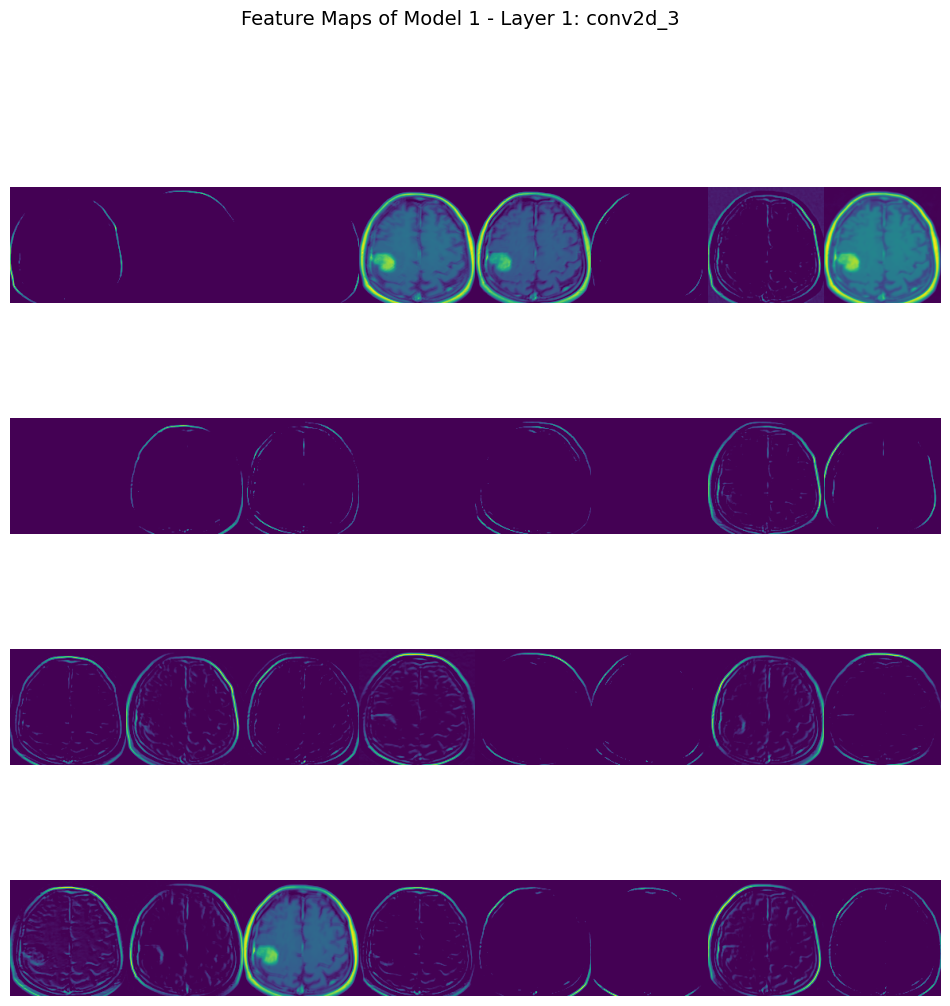

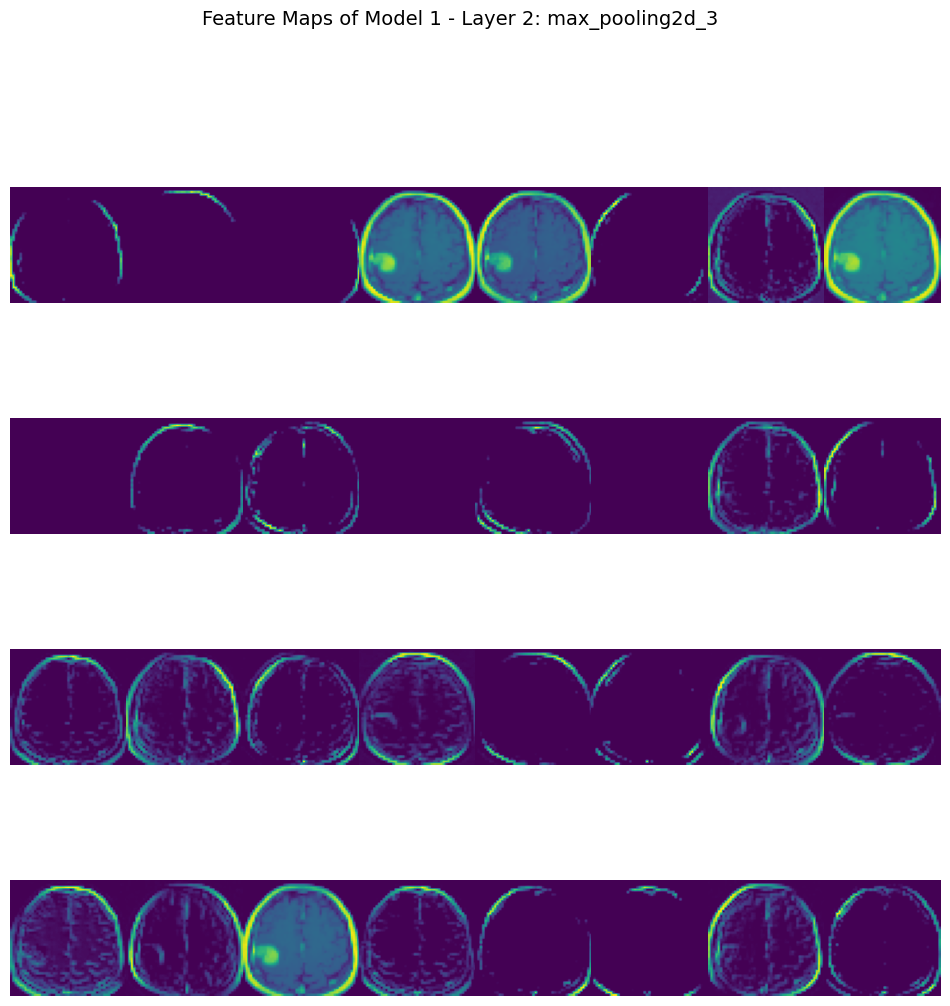

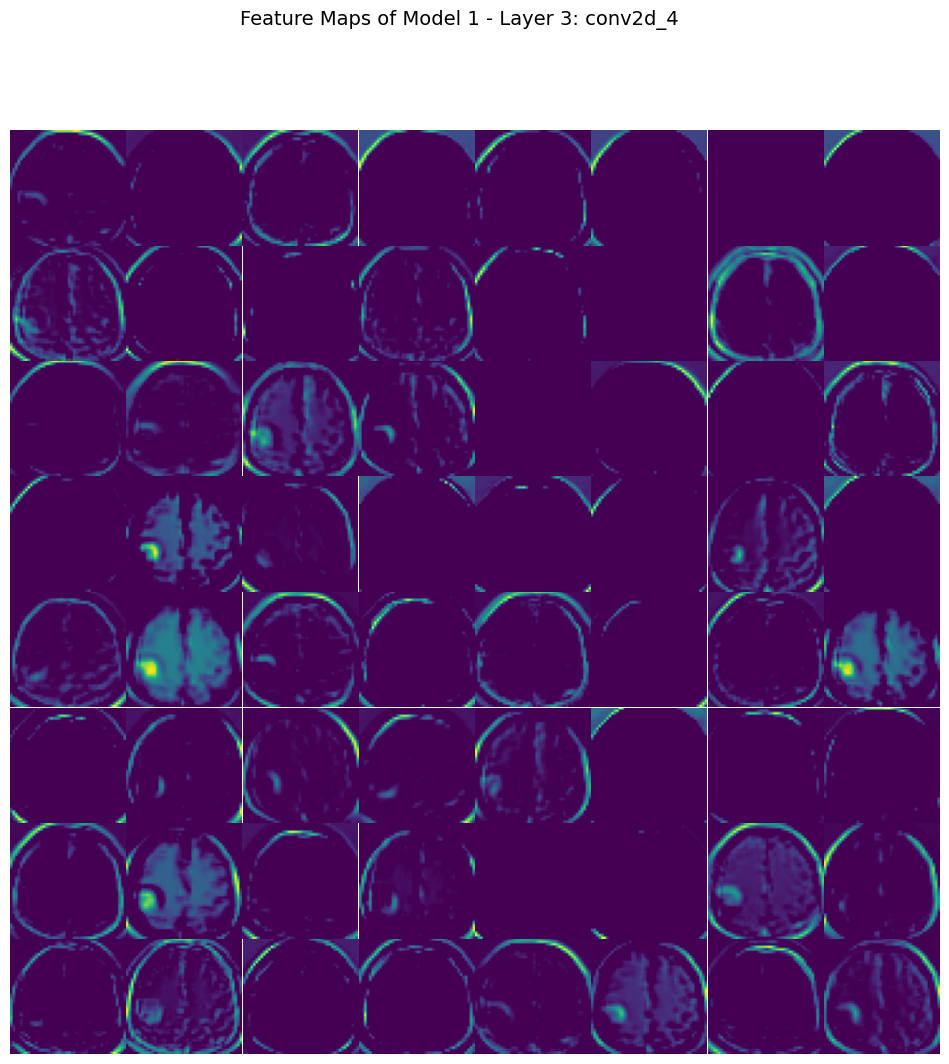

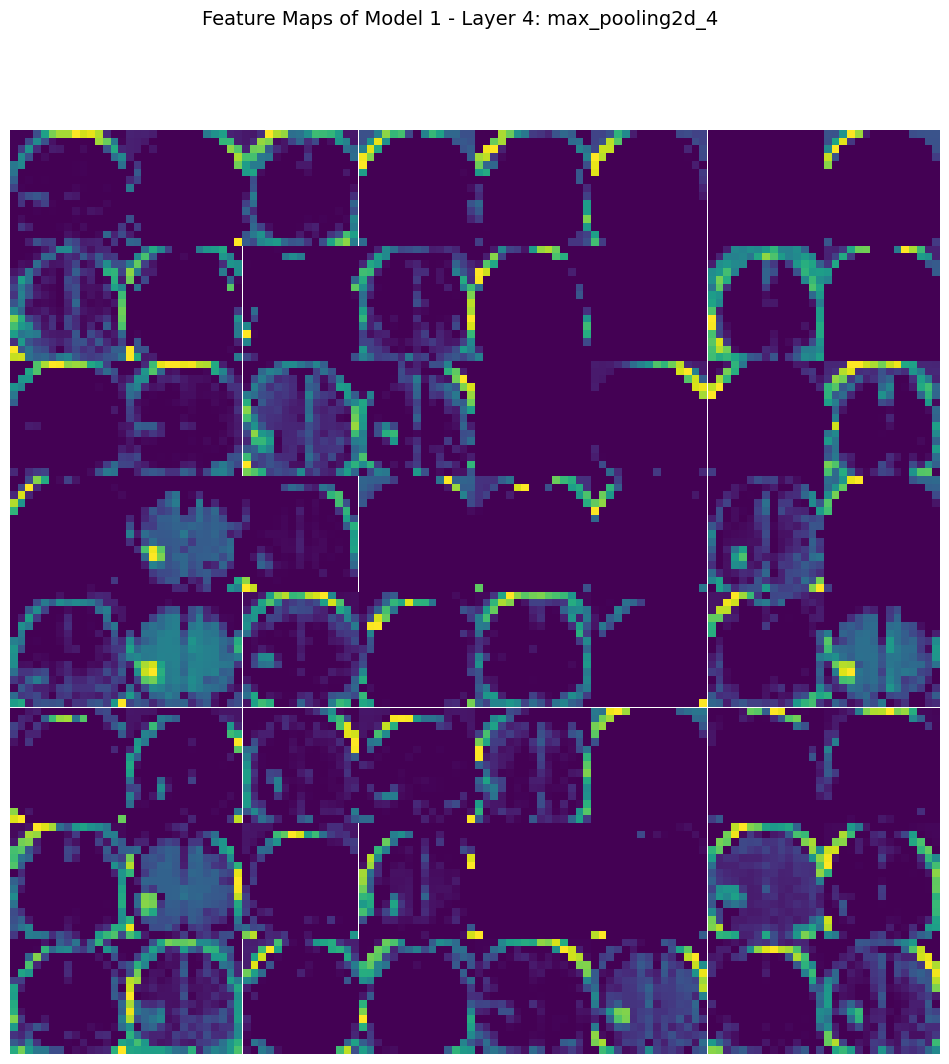

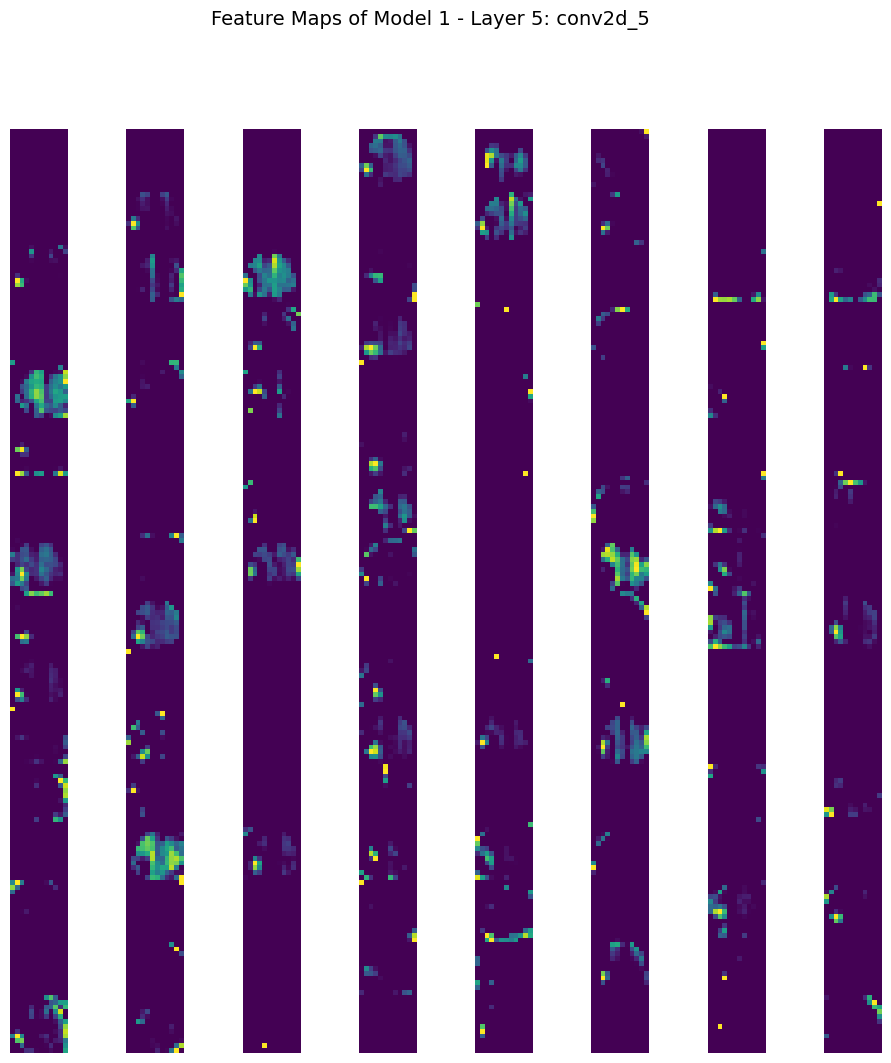

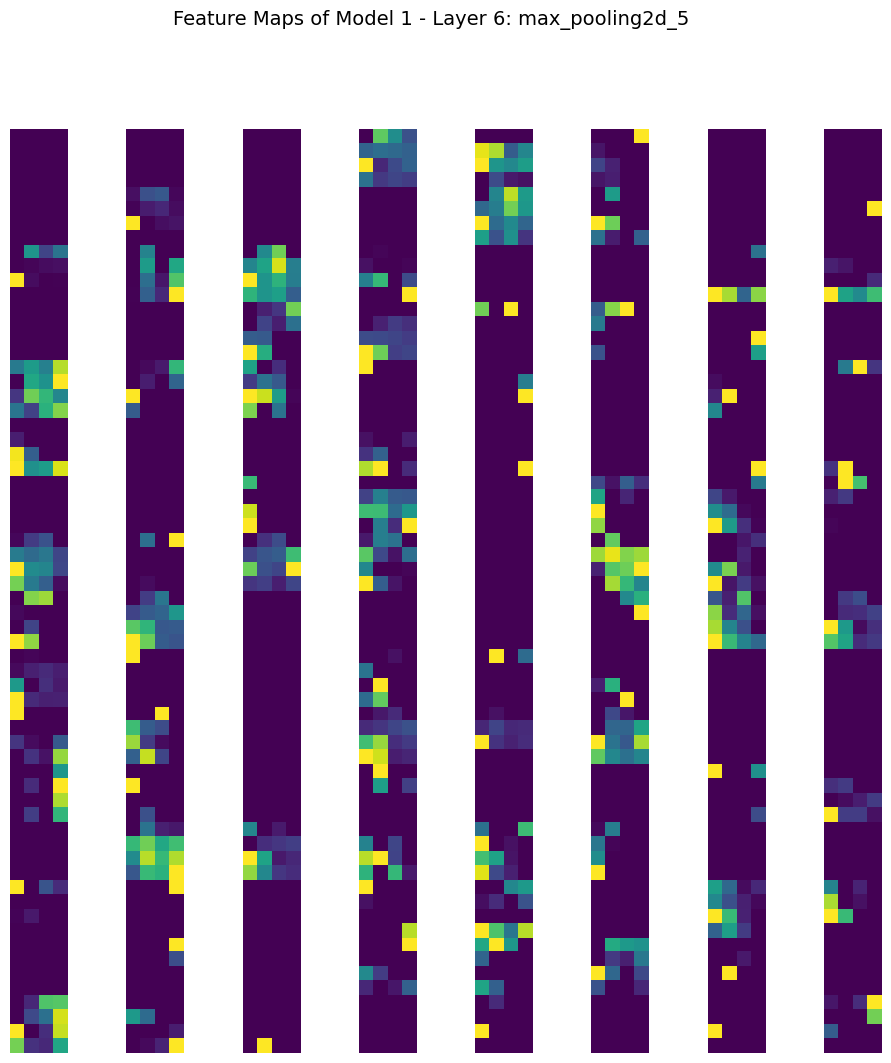


========== Feature Maps for Model 6 ==========


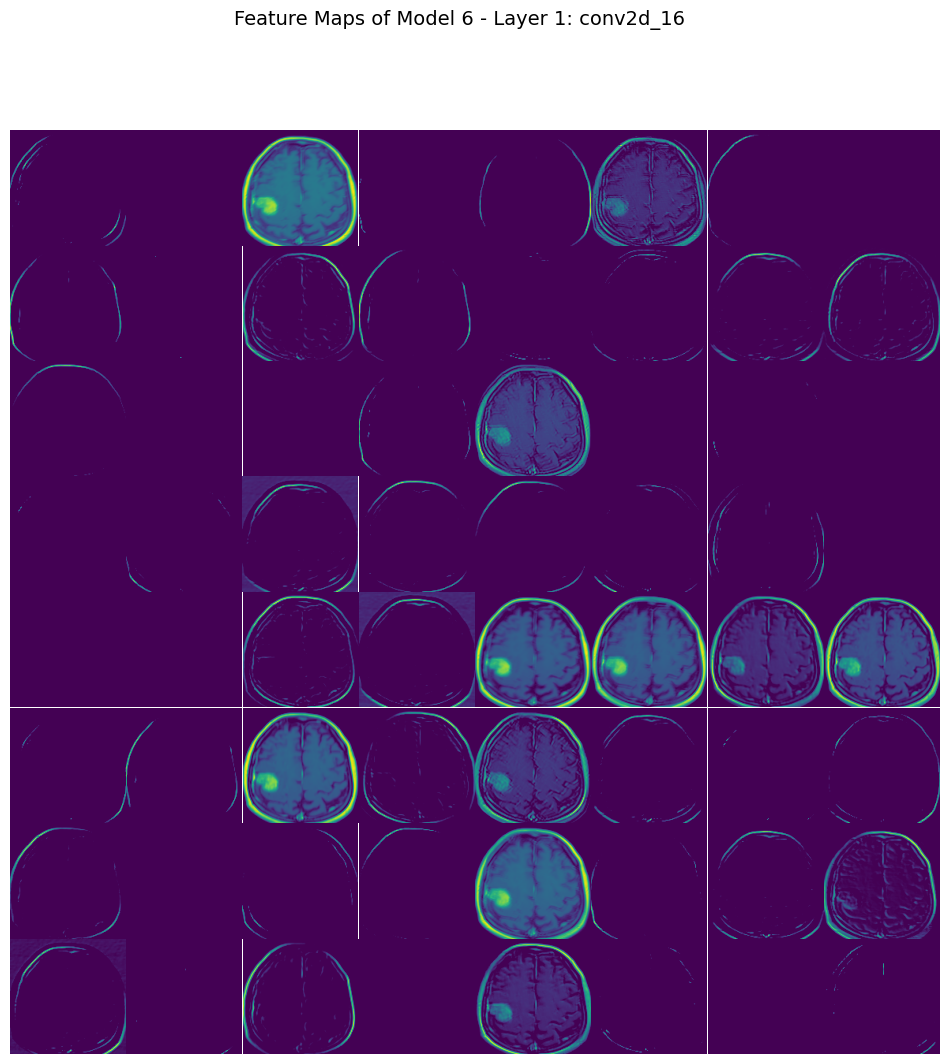

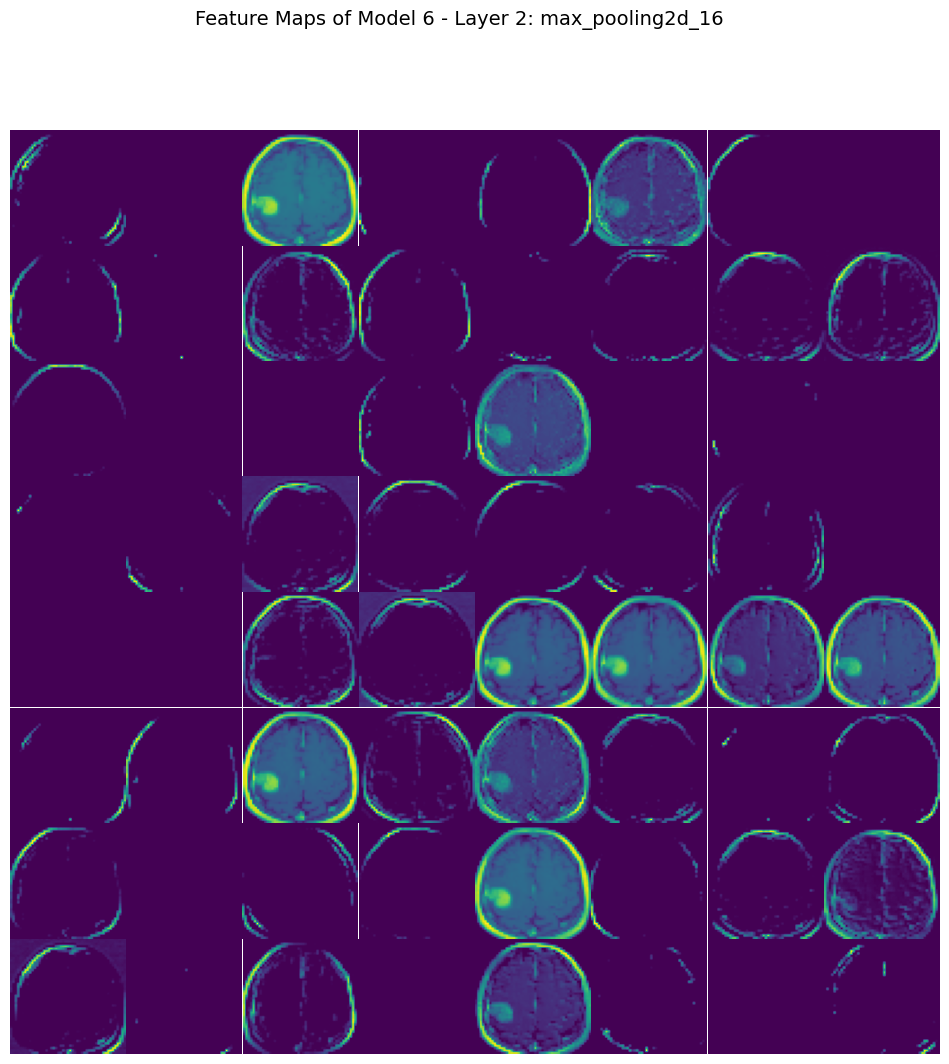

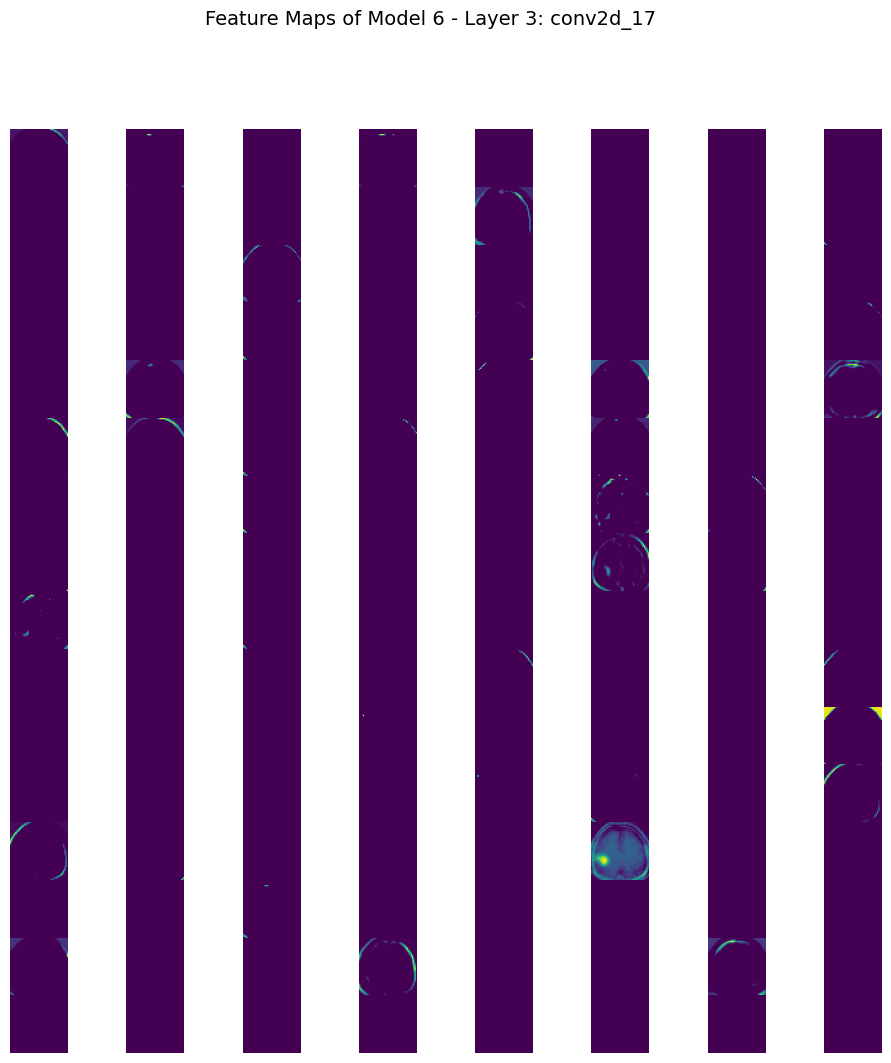

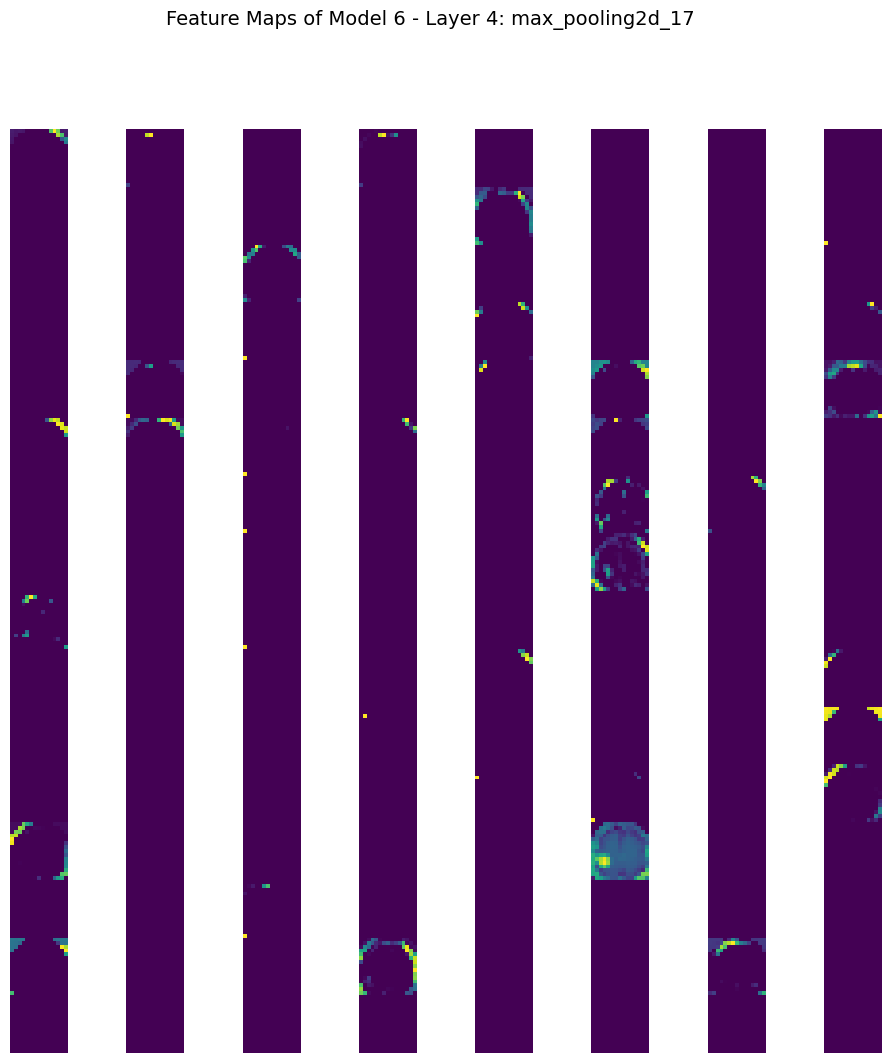

In [32]:
#Bloque 11
sample_image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0023.jpg'

model_path1 = f'/kaggle/working/best_model_arch_1.keras'
model_path2 = f'/kaggle/working/best_model_arch_6.keras'
visualize_feature_maps(model_path1, sample_image_path, img_size, model_id=1)
visualize_feature_maps(model_path2, sample_image_path, img_size, model_id=6)

### **Análisis de Feature Maps**

Los *feature maps* muestran cómo las redes convolucionales procesan las imágenes para identificar los patrones más importantes. Estas imágenes ayudan a entender qué partes de la imagen analiza el modelo en cada etapa. En este caso, se utilizó una imagen de un tumor de meningioma (imagen 27) porque es fácil identificar la ubicación del tumor, lo que permite observar cómo la red detecta sus características.

---

### **Modelo 1**

#### **Capa Convolucional 1**
- **Observaciones:**
  - Resalta bordes y contornos básicos del cerebro.
  - Se diferencian claramente las áreas internas del fondo.
- **Interpretación:**
  - Esta capa capta formas básicas que serán usadas como base por las capas siguientes.

#### **MaxPooling 1**
- **Observaciones:**
  - Reduce la resolución, pero mantiene los contornos importantes.
- **Interpretación:**
  - Simplifica la imagen, conservando lo más importante para el modelo.

#### **Capa Convolucional 2**
- **Observaciones:**
  - Empiezan a aparecer texturas internas y patrones más complejos, como zonas relacionadas con anomalías.
- **Interpretación:**
  - La red profundiza en detalles específicos del cerebro, como texturas que podrían indicar tumores.

#### **MaxPooling 2**
- **Observaciones:**
  - Se reduce aún más la información, destacando las áreas más relevantes.
- **Interpretación:**
  - Filtra el ruido, dejando patrones clave para la siguiente capa.

#### **Capa Convolucional 3**
- **Observaciones:**
  - Los patrones son más abstractos y resaltan estructuras internas del cerebro.
- **Interpretación:**
  - Esta capa se enfoca en detectar diferencias importantes, como tejido sano frente a tejido tumoral.

#### **MaxPooling 3**
- **Observaciones:**
  - Solo quedan las características más significativas.
- **Interpretación:**
  - El modelo se queda con lo más esencial para tomar una decisión de clasificación.

---

### **Modelo 2**

#### **Capa Convolucional 1**
- **Observaciones:**
  - Los bordes y contornos básicos son menos claros que en el Modelo 1.
- **Interpretación:**
  - Detecta formas básicas, pero con menos precisión.

#### **MaxPooling 1**
- **Observaciones:**
  - Se pierde mucha información, y los contornos son menos visibles.
- **Interpretación:**
  - La reducción de datos elimina detalles importantes que podrían ser útiles.

#### **Capa Convolucional 2**
- **Observaciones:**
  - Aparecen texturas internas, pero son menos detalladas que en el Modelo 1.
- **Interpretación:**
  - Tiene menos capacidad para detectar patrones más complejos.

#### **MaxPooling 2**
- **Observaciones:**
  - La información se simplifica, pero se pierde claridad en los detalles importantes.
- **Interpretación:**
  - Filtra demasiado, afectando la capacidad del modelo de captar detalles clave.

#### **Capa Convolucional 3**
- **Observaciones:**
  - Los patrones son más abstractos, pero menos útiles que en el Modelo 1.
- **Interpretación:**
  - No logra extraer características avanzadas con la misma calidad.

#### **MaxPooling 3**
- **Observaciones:**
  - Quedan patrones muy simples, con poca información útil.
- **Interpretación:**
  - Simplifica en exceso, dejando al modelo con poca información para clasificar correctamente.

---

### **Comparación entre Modelos**

- **Modelo 1:**
  - Extrae patrones más detallados y útiles para identificar tumores.
  - Conserva información importante en cada etapa, logrando un mejor procesamiento.
  - Sus *feature maps* muestran cómo la información se vuelve más compleja y relevante a medida que avanza por las capas.

- **Modelo 2:**
  - Pierde detalles importantes, especialmente en las etapas de MaxPooling.
  - No capta características complejas con la misma eficiencia, lo que reduce su capacidad para clasificar con precisión.

---

### **Propósito de los Feature Maps**

El propósito de los *feature maps* es mostrar cómo las redes convolucionales analizan y procesan las imágenes. Permiten entender qué patrones son importantes para el modelo y cómo los detecta. En el caso de tumores cerebrales, estos mapas visuales ayudan a explicar cómo el modelo distingue entre tejido sano y tumoral, lo que es crucial para un diagnóstico más confiable.

---

### **Observación**

El **modelo 1** es más eficiente al procesar imágenes. Sus *feature maps* muestran que conserva y mejora la información relevante en cada etapa, lo que lo hace más adecuado para identificar tumores cerebrales. Por otro lado, el **modelo 2** pierde demasiados detalles importantes, lo que limita su capacidad de clasificación. Los *feature maps* son útiles porque nos ayudan a entender cómo las redes trabajan internamente, lo que da confianza en su desempeño en tareas médicas críticas.

En el **modelo 1**, se observa que la primera capa convolucional genera menos imágenes en los *feature maps* porque utiliza una menor cantidad de filtros en comparación con las capas posteriores. Esto es normal, ya que las primeras capas están diseñadas para capturar características más simples, como contornos y bordes básicos, mientras que las capas más profundas incrementan el número de filtros para detectar patrones más complejos y detallados, esenciales para diferenciar tejidos sanos de tumores.



## Conclusión

El proyecto abordó la clasificación de imágenes de resonancia magnética (MRI) en cuatro categorías: **Glioma, Meningioma, Pituitario y No Tumor**. Utilizando el dataset **Brain Tumor MRI Dataset** de Kaggle, se diseñaron y entrenaron múltiples modelos de redes neuronales convolucionales (CNNs). El enfoque principal fue maximizar el **recall**, reduciendo falsos negativos para garantizar un diagnóstico preciso, vital en el ámbito clínico.

#### **Parámetros Seleccionados**
Basado en el análisis detallado en la sección **Identificación y Justificación de los Mejores Parámetros**, se eligió al **modelo 1** como el mejor candidato debido a:
- **Optimización**:
  - **Adam** como optimizador, proporcionando estabilidad y adaptabilidad en el aprendizaje.
  - **Categorical Crossentropy** como función de pérdida, ideal para clasificación multiclase.
- **Arquitectura**:
  - Tres capas convolucionales con 32, 64 y 128 filtros, lo que permitió extraer características complejas.
  - Una capa densa de 512 unidades, fortaleciendo la capacidad de aprendizaje.
  - Uso de **Dropout (0.5)** para mejorar la generalización.
- **Aumento de Datos**:
  - Rotación moderada (20°), rango de brillo controlado (0.85–1.15), y mayor shear_range (12.5) sin zoom, preservando la integridad de las imágenes médicas.
- **RGB**:
  - El uso de imágenes a color permitió capturar más detalles visuales relevantes, mejorando el reconocimiento de patrones clave.

Aunque el tiempo de ejecución del modelo 1 fue **790.04 segundos**, superó significativamente a otros modelos en términos de recall y estabilidad, siendo el más adecuado para minimizar errores críticos en contextos médicos.

#### **Retos Encontrados**
- **Entrenamiento lento**: La limitación de recursos en Kaggle y computadoras locales hizo que el entrenamiento de múltiples modelos CNN fuera un proceso lento y computacionalmente costoso.
- **Redes preentrenadas**: Se intentó usar redes preentrenadas mencionadas en estudios como "Brain Tumor Diagnosis and Classification via Pre-Trained Convolutional Neural Networks" ([arxiv.org](https://arxiv.org/abs/2208.00768)), pero estas resultaron demasiado pesadas y lentas para los recursos disponibles. Por ello, se optó por entrenar una red desde cero, adaptada a las necesidades y limitaciones del proyecto.

#### **Conclusión Final**
El **modelo 1** demostró ser el más robusto para la tarea, destacándose por su precisión, capacidad de generalización, y enfoque en maximizar el recall. Aunque su entrenamiento fue más lento, su rendimiento justifica su implementación en un entorno clínico, donde minimizar falsos negativos es crítico para el diagnóstico temprano y preciso de tumores cerebrales.